In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import gc  # For memory cleanup

# Memory-efficient chunked loading
def load_parquet_in_chunks(file_path, sample_size=None, use_row_groups=True):
    """
    Load parquet file in chunks to save memory.
    
    Parameters:
    -----------
    file_path : Path or str
        Path to parquet file
    sample_size : int, optional
        If provided, only load this many rows (for EDA). 
        If None, loads full dataset in chunks.
    use_row_groups : bool
        If True, use pyarrow row groups for efficient chunking
    
    Returns:
    --------
    DataFrame
    """
    parquet_file = pq.ParquetFile(file_path)
    total_rows = parquet_file.metadata.num_rows
    num_row_groups = parquet_file.num_row_groups
    
    print(f"Total rows in file: {total_rows:,}")
    print(f"Number of row groups: {num_row_groups}")
    
    if sample_size and sample_size < total_rows:
        print(f"Sampling {sample_size:,} rows for EDA...")
        # Load full file but sample it
        # For very large files, we'll load row groups and sample from them
        if use_row_groups and num_row_groups > 1:
            # Sample row groups proportionally
            rows_per_group = total_rows // num_row_groups
            sample_per_group = max(1, sample_size // num_row_groups)
            
            chunks = []
            for i in range(num_row_groups):
                chunk = parquet_file.read_row_group(i).to_pandas()
                if len(chunk) > sample_per_group:
                    chunk = chunk.sample(n=min(sample_per_group, len(chunk)), random_state=42)
                chunks.append(chunk)
                print(f"  Loaded row group {i+1}/{num_row_groups} ({len(chunk):,} rows)")
            
            df = pd.concat(chunks, ignore_index=True)
            # If we got more than sample_size, sample again
            if len(df) > sample_size:
                df = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
        else:
            # Fallback: load and sample
            df = pd.read_parquet(file_path, engine='pyarrow')
            df = df.sample(n=min(sample_size, len(df)), random_state=42).reset_index(drop=True)
    else:
        # Load full dataset in row groups
        print(f"Loading full dataset in {num_row_groups} row groups...")
        chunks = []
        for i in range(num_row_groups):
            chunk = parquet_file.read_row_group(i).to_pandas()
            chunks.append(chunk)
            print(f"  Loaded row group {i+1}/{num_row_groups} ({len(chunk):,} rows)")
        
        df = pd.concat(chunks, ignore_index=True)
    
    # Optimize dtypes to save memory
    print("\nOptimizing data types to save memory...")
    for col in df.columns:
        col_type = df[col].dtype
        if col_type == 'int64':
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
        elif col_type == 'float64':
            df[col] = pd.to_numeric(df[col], downcast='float')
    
    print(f" Loaded {len(df):,} rows total")
    return df

# File paths
yellow_taxi_august = Path("../Dataset/yellow_tripdata_2025-08.parquet")
yellow_taxi_sept = Path("../Dataset/yellow_tripdata_2025-09.parquet")

# Load September data (main dataset for EDA)
# For EDA with limited RAM, using 1M rows to save memory
# Adjust sample_size based on your needs:
#   - None: Load full dataset (uses more memory)
#   - 1000000: Load 1M rows (recommended for EDA with limited RAM)
#   - 500000: Load 500K rows (if still running out of memory)
print("=" * 80)
print("Loading September Yellow Taxi Data...")
print("=" * 80)
sept_yellow_df = load_parquet_in_chunks(yellow_taxi_sept, sample_size=1000000)

print("\n" + "=" * 80)
print("Loading August Yellow Taxi Data (sample for comparison)...")
print("=" * 80)
august_yellow_df = load_parquet_in_chunks(yellow_taxi_august, sample_size=250000)

print("\n" + "=" * 80)
print("Data loaded successfully!")
print("=" * 80)
print(f"September dataset shape: {sept_yellow_df.shape}")
print(f"August dataset shape: {august_yellow_df.shape}")
print(f"\nMemory usage:")
sept_mem = sept_yellow_df.memory_usage(deep=True).sum() / 1024**2
aug_mem = august_yellow_df.memory_usage(deep=True).sum() / 1024**2
print(f"September: {sept_mem:.2f} MB")
print(f"August: {aug_mem:.2f} MB")
print(f"Total: {sept_mem + aug_mem:.2f} MB")

# Clean up memory
gc.collect()
print("\n✓ Memory cleanup completed")

# Optional: Delete August dataframe if you only need September data
# Uncomment the line below to free ~64 MB of memory:
# del august_yellow_df
# gc.collect()

sept_yellow_df.head()

Loading September Yellow Taxi Data...
Total rows in file: 4,251,015
Number of row groups: 5
Sampling 1,000,000 rows for EDA...
  Loaded row group 1/5 (200,000 rows)
  Loaded row group 2/5 (200,000 rows)
  Loaded row group 3/5 (200,000 rows)
  Loaded row group 4/5 (200,000 rows)
  Loaded row group 5/5 (56,711 rows)

Optimizing data types to save memory...
 Loaded 856,711 rows total

Loading August Yellow Taxi Data (sample for comparison)...
Total rows in file: 3,574,091
Number of row groups: 4
Sampling 250,000 rows for EDA...
  Loaded row group 1/4 (62,500 rows)
  Loaded row group 2/4 (62,500 rows)
  Loaded row group 3/4 (62,500 rows)
  Loaded row group 4/4 (62,500 rows)

Optimizing data types to save memory...
 Loaded 250,000 rows total

Data loaded successfully!
September dataset shape: (856711, 20)
August dataset shape: (250000, 20)

Memory usage:
September: 111.20 MB
August: 31.91 MB
Total: 143.11 MB

✓ Memory cleanup completed


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,1,2025-09-05 18:43:19,2025-09-05 19:10:21,2.0,4.60,1.0,N,211,237,1,28.200001,5.75,0.5,0.00,0.0,1.0,35.450001,2.5,0.0,0.75
1,2,2025-09-10 08:22:06,2025-09-10 08:44:31,1.0,1.18,1.0,N,186,137,2,19.100000,0.00,0.5,0.00,0.0,1.0,23.850000,2.5,0.0,0.75
2,2,2025-09-10 15:20:45,2025-09-10 15:22:38,3.0,0.37,1.0,N,50,48,2,4.400000,0.00,0.5,0.00,0.0,1.0,9.150000,2.5,0.0,0.75
3,2,2025-09-08 21:53:00,2025-09-08 22:11:49,1.0,7.97,1.0,N,141,66,1,33.799999,1.00,0.5,7.91,0.0,1.0,47.459999,2.5,0.0,0.75
4,2,2025-09-07 14:27:03,2025-09-07 14:38:06,1.0,1.62,1.0,N,107,100,1,12.100000,0.00,0.5,2.00,0.0,1.0,18.850000,2.5,0.0,0.75


In [2]:
# Memory Management Tips:
# =======================
# 1. If you run out of memory, reduce sample_size:
#    - sept_yellow_df: Try 500000 instead of 1000000
#    - august_yellow_df: Try 100000 instead of 250000
#
# 2. To load full dataset (if you have enough RAM):
#    - Set sample_size=None in load_parquet_in_chunks()
#
# 3. To free memory, delete dataframes you don't need:
#    - del august_yellow_df  # If you only need September data
#    - del X_processed  # After you're done with processed data
#    - gc.collect()  # Force garbage collection
#
# 4. Memory optimizations already applied:
#    - Reduced sample sizes (1M instead of 2M)
#    - Sparse matrices for OneHotEncoder
#    - Reduced RandomForest complexity (50 trees, max_depth=15)
#    - Automatic memory cleanup after large operations
#
# 5. Monitor memory usage (optional - requires psutil):
try:
    import psutil
    import os
    
    def get_memory_usage():
        """Get current memory usage in GB"""
        process = psutil.Process(os.getpid())
        mem_info = process.memory_info()
        return mem_info.rss / 1024**3  # Convert to GB
    
    def print_memory_status():
        """Print current memory status"""
        process = psutil.Process(os.getpid())
        mem_info = process.memory_info()
        virtual_mem = psutil.virtual_memory()
        
        print(f"\n{'='*60}")
        print(f"Memory Status:")
        print(f"{'='*60}")
        print(f"Process memory usage: {mem_info.rss / 1024**3:.2f} GB")
        print(f"Total RAM: {virtual_mem.total / 1024**3:.2f} GB")
        print(f"Available RAM: {virtual_mem.available / 1024**3:.2f} GB")
        print(f"Used RAM: {virtual_mem.used / 1024**3:.2f} GB ({virtual_mem.percent:.1f}%)")
        print(f"{'='*60}\n")
    
    # Print initial memory status
    print_memory_status()
    
except ImportError:
    print("psutil not installed. Install with: pip install psutil")
    print("Memory monitoring disabled.")
    print("To enable: pip install psutil")
    
    # Dummy function if psutil not available
    def print_memory_status():
        print("Memory monitoring not available. Install psutil to enable.")



Memory Status:
Process memory usage: 2.58 GB
Total RAM: 22.84 GB
Available RAM: 9.82 GB
Used RAM: 13.02 GB (57.0%)



In [3]:
sept_yellow_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,1,2025-09-05 18:43:19,2025-09-05 19:10:21,2.0,4.60,1.0,N,211,237,1,28.200001,5.75,0.5,0.00,0.0,1.0,35.450001,2.5,0.0,0.75
1,2,2025-09-10 08:22:06,2025-09-10 08:44:31,1.0,1.18,1.0,N,186,137,2,19.100000,0.00,0.5,0.00,0.0,1.0,23.850000,2.5,0.0,0.75
2,2,2025-09-10 15:20:45,2025-09-10 15:22:38,3.0,0.37,1.0,N,50,48,2,4.400000,0.00,0.5,0.00,0.0,1.0,9.150000,2.5,0.0,0.75
3,2,2025-09-08 21:53:00,2025-09-08 22:11:49,1.0,7.97,1.0,N,141,66,1,33.799999,1.00,0.5,7.91,0.0,1.0,47.459999,2.5,0.0,0.75
4,2,2025-09-07 14:27:03,2025-09-07 14:38:06,1.0,1.62,1.0,N,107,100,1,12.100000,0.00,0.5,2.00,0.0,1.0,18.850000,2.5,0.0,0.75


In [4]:
sept_yellow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856711 entries, 0 to 856710
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               856711 non-null  int32         
 1   tpep_pickup_datetime   856711 non-null  datetime64[us]
 2   tpep_dropoff_datetime  856711 non-null  datetime64[us]
 3   passenger_count        607358 non-null  float32       
 4   trip_distance          856711 non-null  float64       
 5   RatecodeID             607358 non-null  float32       
 6   store_and_fwd_flag     607358 non-null  object        
 7   PULocationID           856711 non-null  int32         
 8   DOLocationID           856711 non-null  int32         
 9   payment_type           856711 non-null  int32         
 10  fare_amount            856711 non-null  float32       
 11  extra                  856711 non-null  float32       
 12  mta_tax                856711 non-null  floa

In [5]:
sept_yellow_df.describe(include="all")

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
count,856711.000000,856711,856711,607358.000000,856711.000000,607358.000000,607358,856711.000000,856711.000000,856711.000000,856711.000000,856711.000000,856711.000000,856711.000000,856711.000000,856711.000000,856711.000000,607358.000000,607358.000000,856711.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,605497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.876494,2025-09-17 01:06:29.002366,2025-09-17 01:25:09.087742,1.264669,8.806398,3.742330,NaN,160.524532,160.345932,0.875813,19.028339,1.073753,0.476170,2.721840,0.512534,0.945020,27.393223,2.151715,0.150868,0.534596
min,1.000000,2025-08-31 23:45:38,2025-08-31 23:46:43,0.000000,0.000000,1.000000,NaN,1.000000,1.000000,0.000000,-998.000000,-7.500000,-0.500000,-88.550003,-106.930000,-1.000000,-1002.250000,-2.500000,-1.750000,-0.750000
25%,2.000000,2025-09-09 16:46:10.500000,2025-09-09 17:07:25.500000,1.000000,1.080000,1.000000,NaN,114.000000,107.000000,0.000000,9.300000,0.000000,0.500000,0.000000,0.000000,1.000000,16.180000,2.500000,0.000000,0.000000
50%,2.000000,2025-09-17 06:08:33,2025-09-17 06:25:50,1.000000,1.950000,1.000000,NaN,161.000000,162.000000,1.000000,14.900000,0.000000,0.500000,2.000000,0.000000,1.000000,22.100000,2.500000,0.000000,0.750000
75%,2.000000,2025-09-24 22:42:57,2025-09-24 22:59:00,1.000000,4.000000,1.000000,NaN,232.000000,233.000000,1.000000,24.000000,2.500000,0.500000,3.920000,0.000000,1.000000,31.629999,2.500000,0.000000,0.750000
max,7.000000,2025-09-30 23:59:59,2025-10-01 22:04:37,8.000000,318608.570000,99.000000,NaN,265.000000,265.000000,4.000000,850.000000,38.610001,10.500000,130.000000,106.930000,1.000000,854.250000,2.500000,6.750000,1.500000


In [6]:
store_fwd_flag_dist = sept_yellow_df["store_and_fwd_flag"].value_counts()
print(store_fwd_flag_dist)

store_and_fwd_flag
N    605497
Y      1861
Name: count, dtype: int64


# Detailed EDA on September Yellow Taxi Data

## Step 1: Missing Values Analysis


In [7]:
missing_data = sept_yellow_df.isnull().sum()
missing_percent = (missing_data / len(sept_yellow_df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percent
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if len(missing_df) > 0:
    print("\nColumns with missing values:")
    print(missing_df)
else:
    print("\nNo missing values found!")

print(f"\nTotal missing values: {missing_data.sum()}")
print(f"Total records: {len(sept_yellow_df)}")
print(f"Percentage of records with at least one missing value: {(sept_yellow_df.isnull().any(axis=1).sum() / len(sept_yellow_df)) * 100:.2f}%")



Columns with missing values:
                      Missing Count  Missing Percentage
passenger_count              249353           29.105848
RatecodeID                   249353           29.105848
store_and_fwd_flag           249353           29.105848
congestion_surcharge         249353           29.105848
Airport_fee                  249353           29.105848

Total missing values: 1246765
Total records: 856711
Percentage of records with at least one missing value: 29.11%


## Step 1.5: Missing Data Pattern

In [8]:
# Step 1: Check if missing values occur in the same rows (systematic missingness)
missing_cols = ['passenger_count', 'RatecodeID', 'store_and_fwd_flag',
                'congestion_surcharge', 'Airport_fee']

print("\n1. Checking if missing values occur in the same rows:")
print("-" * 80)

# Check if all missing columns have missing values in the same rows
missing_mask = sept_yellow_df[missing_cols].isnull().any(axis=1)
rows_with_any_missing = missing_mask.sum()
print(f"Rows with at least one missing value: {rows_with_any_missing:,}")

# Check if missing values are in ALL the same rows
missing_all_cols = sept_yellow_df[missing_cols].isnull().all(axis=1)
rows_with_all_missing = missing_all_cols.sum()
print(f"Rows with ALL missing values in these columns: {rows_with_all_missing:,}")

if int(rows_with_any_missing) == int(rows_with_all_missing):
    print(" All missing values occur in the same rows (SYSTEMATIC MISSINGNESS)")
else:
    print(f"⚠ Only {rows_with_all_missing/rows_with_any_missing*100:.2f}% of rows with missing data have all columns missing")

# Check individual column missing patterns
print("\n2. Individual column missing pattern:")
print("-" * 80)
for col in missing_cols:
    col_missing = sept_yellow_df[col].isnull().sum()
    print(f"{col}: {col_missing:,} missing ({col_missing/len(sept_yellow_df)*100:.2f}%)")



1. Checking if missing values occur in the same rows:
--------------------------------------------------------------------------------
Rows with at least one missing value: 249,353
Rows with ALL missing values in these columns: 249,353
 All missing values occur in the same rows (SYSTEMATIC MISSINGNESS)

2. Individual column missing pattern:
--------------------------------------------------------------------------------
passenger_count: 249,353 missing (29.11%)
RatecodeID: 249,353 missing (29.11%)
store_and_fwd_flag: 249,353 missing (29.11%)
congestion_surcharge: 249,353 missing (29.11%)
Airport_fee: 249,353 missing (29.11%)


In [9]:
# Step 3: Check relationship with Payment Type (noticed payment_type 0 = 25.10%, same as missing %)
print("\n4. Investigating Payment Type 0 and Missing Data Relationship:")
print("-" * 80)

# Create a flag for missing data if it doesn't exist
missing_cols = ['passenger_count', 'RatecodeID', 'store_and_fwd_flag',
                'congestion_surcharge', 'Airport_fee']
if 'has_missing' not in sept_yellow_df.columns:
    sept_yellow_df['has_missing'] = sept_yellow_df[missing_cols].isnull().any(axis=1)

# Check if payment_type 0 corresponds to missing data
payment_0_missing = (sept_yellow_df['payment_type'] == 0) & (sept_yellow_df['has_missing'] == True)
payment_0_total = (sept_yellow_df['payment_type'] == 0).sum()
payment_0_missing_count = payment_0_missing.sum()

print(f"Total rows with payment_type = 0: {payment_0_total:,} ({payment_0_total/len(sept_yellow_df)*100:.2f}%)")
print(f"Rows with payment_type = 0 AND missing data: {payment_0_missing_count:,}")
print(f"Percentage of payment_type 0 with missing data: {payment_0_missing_count/payment_0_total*100:.2f}%")

if int(payment_0_total) == int(payment_0_missing_count):
    print("ALL payment_type 0 rows have missing data!")
    print("  This suggests payment_type 0 might indicate a specific trip type (e.g., voided, cancelled, or cash)")
elif int(payment_0_missing_count) / int(payment_0_total) > 0.95:
    print(f"Almost all payment_type 0 rows ({int(payment_0_missing_count)/int(payment_0_total)*100:.1f}%) have missing data")
else:
    print(f"  Only {int(payment_0_missing_count)/int(payment_0_total)*100:.2f}% of payment_type 0 rows have missing data")

# Cross-tabulation
print("\n4a. Cross-tabulation: Payment Type vs Missing Data:")
print("-" * 80)
# Convert to pandas for easier manipulation
import pandas as pandas_lib

crosstab = pandas_lib.crosstab(sept_yellow_df['payment_type'], sept_yellow_df['has_missing'], margins=True)
crosstab_pct = crosstab.div(crosstab.sum(axis=1), axis=0) * 100
print("Counts:")
print(crosstab)
print("\nPercentages (by payment_type):")
print(crosstab_pct.round(2))



4. Investigating Payment Type 0 and Missing Data Relationship:
--------------------------------------------------------------------------------
Total rows with payment_type = 0: 249,353 (29.11%)
Rows with payment_type = 0 AND missing data: 249,353
Percentage of payment_type 0 with missing data: 100.00%
ALL payment_type 0 rows have missing data!
  This suggests payment_type 0 might indicate a specific trip type (e.g., voided, cancelled, or cash)

4a. Cross-tabulation: Payment Type vs Missing Data:
--------------------------------------------------------------------------------
Counts:
has_missing    False    True     All
payment_type                        
0                  0  249353  249353
1             510633       0  510633
2              70993       0   70993
3               5228       0    5228
4              20504       0   20504
All           607358  249353  856711

Percentages (by payment_type):
has_missing   False   True   All
payment_type                    
0             

In [10]:
# Step 4: Check temporal patterns in missing data
print("\n5. Temporal Patterns in Missing Data:")
print("-" * 80)

# Import scipy.stats for chi-square test
from scipy import stats

# Extract temporal features if not already done
if 'pickup_hour' not in sept_yellow_df.columns:
    sept_yellow_df['pickup_hour'] = sept_yellow_df['tpep_pickup_datetime'].dt.hour
    sept_yellow_df['pickup_dayofweek'] = sept_yellow_df['tpep_pickup_datetime'].dt.dayofweek

# Ensure has_missing column exists
if 'has_missing' not in sept_yellow_df.columns:
    missing_cols = ['passenger_count', 'RatecodeID', 'store_and_fwd_flag',
                    'congestion_surcharge', 'Airport_fee']
    sept_yellow_df['has_missing'] = sept_yellow_df[missing_cols].isnull().any(axis=1)

# Missing data by hour
print("\n5a. Missing Data by Hour of Day:")
print("-" * 80)
hourly_missing_sum = sept_yellow_df.groupby('pickup_hour')['has_missing'].sum()
hourly_missing_count = sept_yellow_df.groupby('pickup_hour')['has_missing'].count()
hourly_missing_pct = (hourly_missing_sum / hourly_missing_count * 100).round(2)
hourly_summary = pd.DataFrame({
    'missing_count': hourly_missing_sum,
    'total_count': hourly_missing_count,
    'pct_missing': hourly_missing_pct
})
print(hourly_summary.head(10))

# Missing data by day of week
print("\n5b. Missing Data by Day of Week:")
print("-" * 80)
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_missing_sum = sept_yellow_df.groupby('pickup_dayofweek')['has_missing'].sum()
dow_missing_count = sept_yellow_df.groupby('pickup_dayofweek')['has_missing'].count()
dow_missing_pct = (dow_missing_sum / dow_missing_count * 100).round(2)
dow_summary = pd.DataFrame({
    'missing_count': dow_missing_sum,
    'total_count': dow_missing_count,
    'pct_missing': dow_missing_pct
})
dow_summary = dow_summary.rename(index={i: day_names[i] for i in range(len(day_names))})
print(dow_summary)

# Statistical test for temporal patterns
print("\n5c. Chi-square test for independence (Hour vs Missing):")
print("-" * 80)

contingency_hour = pandas_lib.crosstab(sept_yellow_df['pickup_hour'], sept_yellow_df['has_missing'])
chi2_result = stats.chi2_contingency(contingency_hour)
chi2_hour = chi2_result[0]
p_hour = chi2_result[1]
print(f"Chi-square statistic: {chi2_hour:.4f}")
print(f"p-value: {p_hour:.4e}")
print("→ If p-value < 0.05: SIGNIFICANT association (NOT MCAR)")
print("→ If p-value >= 0.05: No significant association (consistent with MCAR)")



5. Temporal Patterns in Missing Data:
--------------------------------------------------------------------------------

5a. Missing Data by Hour of Day:
--------------------------------------------------------------------------------
             missing_count  total_count  pct_missing
pickup_hour                                         
0                    11078        27257        40.64
1                     7428        17483        42.49
2                     5208        11729        44.40
3                     3715         7851        47.32
4                     3422         6365        53.76
5                     3609         7311        49.36
6                     6754        14689        45.98
7                    10994        27023        40.68
8                    12980        34776        37.32
9                    10298        35679        28.86

5b. Missing Data by Day of Week:
--------------------------------------------------------------------------------
              

In [11]:
# Summary and Conclusion
print("\nKey Findings:")
print("-" * 80)

# Check if payment_type 0 is the key
payment_0_total = (sept_yellow_df['payment_type'] == 0).sum()
missing_total = sept_yellow_df['has_missing'].sum()

print(f"\n1. Missing data pattern:")
print(f"   - Total missing rows: {missing_total:,} ({missing_total/len(sept_yellow_df)*100:.2f}%)")
print(f"   - Payment Type 0 rows: {payment_0_total:,} ({payment_0_total/len(sept_yellow_df)*100:.2f}%)")

if int(payment_0_total) == int(missing_total):
    print("PERFECT MATCH: All missing data corresponds to Payment Type 0")
    print("\n2. Missing Data Mechanism:")
    print("   This is MISSING NOT AT RANDOM (MNAR)")
    print("   Missingness is systematically related to payment_type = 0")
    print("   Payment Type 0 likely represents:")
    print("     - Voided/cancelled trips")
    print("     - Cash payments (where some fields aren't recorded)")
    print("     - Special trip types that don't require these fields")
    print("\n3. Implications:")
    print("   Cannot use standard MCAR/MAR imputation methods")
    print("   Should treat payment_type=0 as a separate category")
    print("   Consider separate models for different payment types")
    print("   Or exclude payment_type=0 if those trips aren't relevant")
else:
    print(f" Partial match: {int(missing_total)/int(payment_0_total)*100:.1f}% of payment_type 0 have missing data")
    print("\n2. Further investigation needed to determine:")
    print("   - MCAR: If missingness is completely random")
    print("   - MAR: If missingness depends on observed variables")
    print("   - MNAR: If missingness depends on unobserved variables")

print("\n" + "=" * 80)



Key Findings:
--------------------------------------------------------------------------------

1. Missing data pattern:
   - Total missing rows: 249,353 (29.11%)
   - Payment Type 0 rows: 249,353 (29.11%)
PERFECT MATCH: All missing data corresponds to Payment Type 0

2. Missing Data Mechanism:
   This is MISSING NOT AT RANDOM (MNAR)
   Missingness is systematically related to payment_type = 0
   Payment Type 0 likely represents:
     - Voided/cancelled trips
     - Cash payments (where some fields aren't recorded)
     - Special trip types that don't require these fields

3. Implications:
   Cannot use standard MCAR/MAR imputation methods
   Should treat payment_type=0 as a separate category
   Consider separate models for different payment types
   Or exclude payment_type=0 if those trips aren't relevant



## Step 2: Data Quality Checks - Negative Values and Anomalies


In [12]:
# Check for negative values in columns that should be non-negative
numeric_cols = ['passenger_count', 'trip_distance', 'fare_amount', 'extra',
                'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
                'total_amount', 'congestion_surcharge', 'Airport_fee', 'cbd_congestion_fee']

print("\nNegative Values Check:")
for col in numeric_cols:
    negative_count = (sept_yellow_df[col] < 0).sum()
    if negative_count > 0:
        print(f"{col}: {negative_count:,} negative values ({negative_count/len(sept_yellow_df)*100:.2f}%)")

# Check for zero or invalid trip distances
print("\nTrip Distance Anomalies:")
zero_distance = (sept_yellow_df['trip_distance'] == 0).sum()
print(f"Zero distance trips: {zero_distance:,} ({zero_distance/len(sept_yellow_df)*100:.2f}%)")

# Check for invalid passenger counts
print("\nPassenger Count Anomalies:")
zero_passengers = (sept_yellow_df['passenger_count'] == 0).sum()
print(f"Zero passenger trips: {zero_passengers:,} ({zero_passengers/len(sept_yellow_df)*100:.2f}%)")

# Check for trips where dropoff is before pickup
print("\nTemporal Anomalies:")
invalid_time = (sept_yellow_df['tpep_dropoff_datetime'] < sept_yellow_df['tpep_pickup_datetime']).sum()
print(f"Dropoff before pickup: {invalid_time:,} ({invalid_time/len(sept_yellow_df)*100:.2f}%)")



Negative Values Check:
fare_amount: 56,099 negative values (6.55%)
extra: 7,890 negative values (0.92%)
mta_tax: 14,000 negative values (1.63%)
tip_amount: 30 negative values (0.00%)
tolls_amount: 1,409 negative values (0.16%)
improvement_surcharge: 15,014 negative values (1.75%)
total_amount: 15,061 negative values (1.76%)
congestion_surcharge: 11,612 negative values (1.36%)
Airport_fee: 3,349 negative values (0.39%)
cbd_congestion_fee: 10,028 negative values (1.17%)

Trip Distance Anomalies:
Zero distance trips: 28,527 (3.33%)

Passenger Count Anomalies:
Zero passenger trips: 4,236 (0.49%)

Temporal Anomalies:
Dropoff before pickup: 0 (0.00%)


In [13]:
sept_yellow_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee,has_missing,pickup_hour,pickup_dayofweek
0,1,2025-09-05 18:43:19,2025-09-05 19:10:21,2.0,4.60,1.0,N,211,237,1,...,0.00,0.0,1.0,35.450001,2.5,0.0,0.75,False,18,4
1,2,2025-09-10 08:22:06,2025-09-10 08:44:31,1.0,1.18,1.0,N,186,137,2,...,0.00,0.0,1.0,23.850000,2.5,0.0,0.75,False,8,2
2,2,2025-09-10 15:20:45,2025-09-10 15:22:38,3.0,0.37,1.0,N,50,48,2,...,0.00,0.0,1.0,9.150000,2.5,0.0,0.75,False,15,2
3,2,2025-09-08 21:53:00,2025-09-08 22:11:49,1.0,7.97,1.0,N,141,66,1,...,7.91,0.0,1.0,47.459999,2.5,0.0,0.75,False,21,0
4,2,2025-09-07 14:27:03,2025-09-07 14:38:06,1.0,1.62,1.0,N,107,100,1,...,2.00,0.0,1.0,18.850000,2.5,0.0,0.75,False,14,6


## Step 3: Categorical Variables Analysis


In [14]:
# VendorID distribution
print("\n1. VendorID Distribution:")
print("-" * 60)
vendor_dist = sept_yellow_df['VendorID'].value_counts().sort_index()
print(vendor_dist)
print(f"\nPercentage distribution:")
for vendor, count in vendor_dist.items():
    print(f"  Vendor {vendor}: {count/len(sept_yellow_df)*100:.2f}%")

# Payment Type distribution
print("\n2. Payment Type Distribution:")
print("-" * 60)
payment_dist = sept_yellow_df['payment_type'].value_counts().sort_index()
print(payment_dist)
print(f"\nPercentage distribution:")
for payment, count in payment_dist.items():
    print(f"  Payment Type {payment}: {count/len(sept_yellow_df)*100:.2f}%")

# RatecodeID distribution
print("\n3. RatecodeID Distribution:")
print("-" * 60)
ratecode_dist = sept_yellow_df['RatecodeID'].value_counts().sort_index()
print(ratecode_dist.head(10))  # Show top 10
print(f"\nTotal unique RatecodeIDs: {sept_yellow_df['RatecodeID'].nunique()}")

# Store and forward flag (already done, but including for completeness)
print("\n4. Store and Forward Flag Distribution:")
print("-" * 60)
print(store_fwd_flag_dist)



1. VendorID Distribution:
------------------------------------------------------------
VendorID
1    163355
2    681691
6       779
7     10886
Name: count, dtype: int64

Percentage distribution:
  Vendor 1: 19.07%
  Vendor 2: 79.57%
  Vendor 6: 0.09%
  Vendor 7: 1.27%

2. Payment Type Distribution:
------------------------------------------------------------
payment_type
0    249353
1    510633
2     70993
3      5228
4     20504
Name: count, dtype: int64

Percentage distribution:
  Payment Type 0: 29.11%
  Payment Type 1: 59.60%
  Payment Type 2: 8.29%
  Payment Type 3: 0.61%
  Payment Type 4: 2.39%

3. RatecodeID Distribution:
------------------------------------------------------------
RatecodeID
1.0     555676
2.0      21706
3.0       3029
4.0       2084
5.0       8562
6.0          2
99.0     16299
Name: count, dtype: int64

Total unique RatecodeIDs: 7

4. Store and Forward Flag Distribution:
------------------------------------------------------------
store_and_fwd_flag
N    605

In [15]:
# Step 2: Compare characteristics of rows with missing vs non-missing data
print("\n3. Comparing characteristics of missing vs non-missing rows:")
print("-" * 80)

# Define missing_cols if not already defined
missing_cols = ['passenger_count', 'RatecodeID', 'store_and_fwd_flag',
                'congestion_surcharge', 'Airport_fee']

# Create a flag for missing data (if not already created)
if 'has_missing' not in sept_yellow_df.columns:
    sept_yellow_df['has_missing'] = sept_yellow_df[missing_cols].isnull().any(axis=1)

# Create trip_duration_minutes if it doesn't exist
if 'trip_duration_minutes' not in sept_yellow_df.columns:
    sept_yellow_df['trip_duration_minutes'] = (
        (sept_yellow_df['tpep_dropoff_datetime'] - sept_yellow_df['tpep_pickup_datetime']).dt.total_seconds() / 60
    )

# Compare key variables between missing and non-missing groups
comparison_vars = ['VendorID', 'payment_type', 'trip_distance', 'fare_amount',
                   'total_amount', 'trip_duration_minutes', 'PULocationID', 'DOLocationID']

print("\n3a. Categorical Variables Comparison:")
print("-" * 80)

# VendorID distribution
print("\nVendorID Distribution:")
vendor_comparison = sept_yellow_df.groupby('has_missing')['VendorID'].value_counts(normalize=True).unstack(fill_value=0) * 100
print(vendor_comparison.round(2))

# Payment Type distribution
print("\nPayment Type Distribution:")
payment_comparison = sept_yellow_df.groupby('has_missing')['payment_type'].value_counts(normalize=True).unstack(fill_value=0) * 100
print(payment_comparison.round(2))

print("\n3b. Numerical Variables Comparison (Mean):")
print("-" * 80)
# Filter to only columns that exist
numeric_cols = ['trip_distance', 'fare_amount', 'total_amount', 'trip_duration_minutes']
numeric_cols = [col for col in numeric_cols if col in sept_yellow_df.columns]
numeric_comparison = sept_yellow_df.groupby('has_missing')[numeric_cols].mean()
print(numeric_comparison.round(2))

print("\n3c. Statistical Test for Differences (t-test for means):")
print("-" * 80)
from scipy import stats

missing_group = sept_yellow_df[sept_yellow_df['has_missing'] == True]
non_missing_group = sept_yellow_df[sept_yellow_df['has_missing'] == False]

# Filter to only variables that exist in the dataframe
test_vars = ['trip_distance', 'fare_amount', 'total_amount', 'trip_duration_minutes']
test_vars = [var for var in test_vars if var in sept_yellow_df.columns]

for var in test_vars:
    # Remove NaN values for the test
    missing_vals = missing_group[var].dropna()
    non_missing_vals = non_missing_group[var].dropna()

    if len(missing_vals) > 0 and len(non_missing_vals) > 0:
        t_stat, p_value = stats.ttest_ind(missing_vals, non_missing_vals, equal_var=False)
        print(f"{var}:")
        print(f"  Missing group mean: {missing_vals.mean():.2f}")
        print(f"  Non-missing group mean: {non_missing_vals.mean():.2f}")
        print(f"  t-statistic: {t_stat:.4f}, p-value: {p_value:.4e}")
        if p_value < 0.05:
            print(f"  SIGNIFICANT DIFFERENCE (p < 0.05) - suggests NOT MCAR")
        else:
            print(f"  No significant difference (p >= 0.05)")



3. Comparing characteristics of missing vs non-missing rows:
--------------------------------------------------------------------------------

3a. Categorical Variables Comparison:
--------------------------------------------------------------------------------

VendorID Distribution:
VendorID         1      2     6     7
has_missing                          
False        21.45  76.76  0.00  1.79
True         13.26  86.43  0.31  0.00

Payment Type Distribution:
payment_type      0      1      2     3     4
has_missing                                  
False           0.0  84.07  11.69  0.86  3.38
True          100.0   0.00   0.00  0.00  0.00

3b. Numerical Variables Comparison (Mean):
--------------------------------------------------------------------------------
             trip_distance  fare_amount  total_amount  trip_duration_minutes
has_missing                                                                 
False                 3.49    19.639999         29.10                 

## Step 4: Numerical Variables - Statistical Summary


In [16]:
# Focus on key numerical columns
key_numeric_cols = ['passenger_count', 'trip_distance', 'fare_amount', 'tip_amount',
                    'tolls_amount', 'total_amount']

print("\nStatistical Summary for Key Numerical Variables:")
print("-" * 60)
stats_summary = sept_yellow_df[key_numeric_cols].describe()
print(stats_summary)

# Additional statistics
print("\nAdditional Statistics:")
print("-" * 60)
for col in key_numeric_cols:
    print(f"\n{col}:")
    print(f"  Median: {sept_yellow_df[col].median():.2f}")
    print(f"  Mode: {sept_yellow_df[col].mode().iloc[0] if len(sept_yellow_df[col].mode()) > 0 else 'N/A'}")
    print(f"  Skewness: {sept_yellow_df[col].skew():.2f}")
    print(f"  Kurtosis: {sept_yellow_df[col].kurtosis():.2f}")



Statistical Summary for Key Numerical Variables:
------------------------------------------------------------
       passenger_count  trip_distance    fare_amount     tip_amount  \
count    607358.000000  856711.000000  856711.000000  856711.000000   
mean          1.264669       8.806398      19.028339       2.721840   
std           0.677696     880.441741      19.594219       3.982263   
min           0.000000       0.000000    -998.000000     -88.550003   
25%           1.000000       1.080000       9.300000       0.000000   
50%           1.000000       1.950000      14.900000       2.000000   
75%           1.000000       4.000000      24.000000       3.920000   
max           8.000000  318608.570000     850.000000     130.000000   

        tolls_amount   total_amount  
count  856711.000000  856711.000000  
mean        0.512534      27.393223  
std         2.152092      23.664284  
min      -106.930000   -1002.250000  
25%         0.000000      16.180000  
50%         0.000000 

## Step 5: Outlier Detection


In [17]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

outlier_cols = ['trip_distance', 'fare_amount', 'tip_amount', 'total_amount', 'passenger_count']

print("\nOutlier Analysis:")
print("-" * 60)
for col in outlier_cols:
    outliers, lower, upper = detect_outliers_iqr(sept_yellow_df, col)
    outlier_count = len(outliers)
    outlier_pct = (outlier_count / len(sept_yellow_df)) * 100
    print(f"\n{col}:")
    print(f"  Lower bound: {lower:.2f}, Upper bound: {upper:.2f}")
    print(f"  Outliers: {outlier_count:,} ({outlier_pct:.2f}%)")
    if outlier_count > 0:
        print(f"  Min outlier value: {outliers[col].min():.2f}")
        print(f"  Max outlier value: {outliers[col].max():.2f}")



Outlier Analysis:
------------------------------------------------------------

trip_distance:
  Lower bound: -3.30, Upper bound: 8.38
  Outliers: 94,760 (11.06%)
  Min outlier value: 8.38
  Max outlier value: 318608.57

fare_amount:
  Lower bound: -12.75, Upper bound: 46.05
  Outliers: 70,926 (8.28%)
  Min outlier value: -998.00
  Max outlier value: 850.00

tip_amount:
  Lower bound: -5.88, Upper bound: 9.80
  Outliers: 49,625 (5.79%)
  Min outlier value: -88.55
  Max outlier value: 130.00

total_amount:
  Lower bound: -6.99, Upper bound: 54.80
  Outliers: 91,285 (10.66%)
  Min outlier value: -1002.25
  Max outlier value: 854.25

passenger_count:
  Lower bound: 1.00, Upper bound: 1.00
  Outliers: 118,550 (13.84%)
  Min outlier value: 0.00
  Max outlier value: 8.00


## Step 6: Temporal Analysis - Time-based Features

In [18]:
# Create temporal features
sept_yellow_df['pickup_hour'] = sept_yellow_df['tpep_pickup_datetime'].dt.hour
sept_yellow_df['pickup_day'] = sept_yellow_df['tpep_pickup_datetime'].dt.day
sept_yellow_df['pickup_dayofweek'] = sept_yellow_df['tpep_pickup_datetime'].dt.dayofweek
sept_yellow_df['pickup_month'] = sept_yellow_df['tpep_pickup_datetime'].dt.month
sept_yellow_df['trip_duration_minutes'] = (
    (sept_yellow_df['tpep_dropoff_datetime'] - sept_yellow_df['tpep_pickup_datetime']).dt.total_seconds() / 60
)

print("\n1. Date Range:")
print("-" * 60)
print(f"Pickup date range: {sept_yellow_df['tpep_pickup_datetime'].min()} to {sept_yellow_df['tpep_pickup_datetime'].max()}")
print(f"Dropoff date range: {sept_yellow_df['tpep_dropoff_datetime'].min()} to {sept_yellow_df['tpep_dropoff_datetime'].max()}")

print("\n2. Trip Duration Statistics:")
print("-" * 60)
print(f"Mean duration: {sept_yellow_df['trip_duration_minutes'].mean():.2f} minutes")
print(f"Median duration: {sept_yellow_df['trip_duration_minutes'].median():.2f} minutes")
print(f"Min duration: {sept_yellow_df['trip_duration_minutes'].min():.2f} minutes")
print(f"Max duration: {sept_yellow_df['trip_duration_minutes'].max():.2f} minutes")
print(f"Std duration: {sept_yellow_df['trip_duration_minutes'].std():.2f} minutes")

# Check for unrealistic trip durations
very_short = (sept_yellow_df['trip_duration_minutes'] < 1).sum()
very_long = (sept_yellow_df['trip_duration_minutes'] > 120).sum()
print(f"\nTrips < 1 minute: {very_short:,} ({very_short/len(sept_yellow_df)*100:.2f}%)")
print(f"Trips > 2 hours: {very_long:,} ({very_long/len(sept_yellow_df)*100:.2f}%)")



1. Date Range:
------------------------------------------------------------
Pickup date range: 2025-08-31 23:45:38 to 2025-09-30 23:59:59
Dropoff date range: 2025-08-31 23:46:43 to 2025-10-01 22:04:37

2. Trip Duration Statistics:
------------------------------------------------------------
Mean duration: 18.67 minutes
Median duration: 14.75 minutes
Min duration: 0.00 minutes
Max duration: 9907.05 minutes
Std duration: 27.47 minutes

Trips < 1 minute: 20,733 (2.42%)
Trips > 2 hours: 681 (0.08%)


In [19]:
# Step 6 (continued): Hourly and Daily Patterns
print("\n3. Hourly Distribution (Pickup Hours):")
print("-" * 60)
hourly_dist = sept_yellow_df['pickup_hour'].value_counts().sort_index()
print(hourly_dist)
print(f"\nPeak hour: {hourly_dist.idxmax()} ({hourly_dist.max():,} trips)")
print(f"Lowest hour: {hourly_dist.idxmin()} ({hourly_dist.min():,} trips)")

print("\n4. Day of Week Distribution:")
print("-" * 60)
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_dist = sept_yellow_df['pickup_dayofweek'].value_counts().sort_index()
for day_num, count in dow_dist.items():
    print(f"{day_names[day_num]}: {count:,} trips ({count/len(sept_yellow_df)*100:.2f}%)")

print("\n5. Daily Distribution (Days of Month):")
print("-" * 60)
daily_dist = sept_yellow_df['pickup_day'].value_counts().sort_index()
print(f"Days with data: {daily_dist.min()} to {daily_dist.max()}")
print(f"Average trips per day: {daily_dist.mean():.0f}")
print(f"Day with most trips: {daily_dist.idxmax()} ({daily_dist.max():,} trips)")
print(f"Day with least trips: {daily_dist.idxmin()} ({daily_dist.min():,} trips)")



3. Hourly Distribution (Pickup Hours):
------------------------------------------------------------
pickup_hour
0     27257
1     17483
2     11729
3      7851
4      6365
5      7311
6     14689
7     27023
8     34776
9     35679
10    35447
11    38257
12    41225
13    42386
14    46442
15    48704
16    49338
17    56846
18    59494
19    54669
20    52789
21    52573
22    49827
23    38551
Name: count, dtype: int64

Peak hour: 18 (59,494 trips)
Lowest hour: 4 (6,365 trips)

4. Day of Week Distribution:
------------------------------------------------------------
Monday: 134,160 trips (15.66%)
Tuesday: 148,645 trips (17.35%)
Wednesday: 109,447 trips (12.78%)
Thursday: 118,162 trips (13.79%)
Friday: 118,047 trips (13.78%)
Saturday: 121,392 trips (14.17%)
Sunday: 106,858 trips (12.47%)

5. Daily Distribution (Days of Month):
------------------------------------------------------------
Days with data: 2 to 50097
Average trips per day: 27636
Day with most trips: 30 (50,097 trips)
Da

## Step 7: Location Analysis


In [20]:
print("\n1. Pickup Location (PULocationID):")
print("-" * 60)
print(f"Unique pickup locations: {sept_yellow_df['PULocationID'].nunique()}")
print(f"Location ID range: {sept_yellow_df['PULocationID'].min()} to {sept_yellow_df['PULocationID'].max()}")
print(f"\nTop 10 Pickup Locations:")
top_pu = sept_yellow_df['PULocationID'].value_counts().head(10)
for loc_id, count in top_pu.items():
    print(f"  Location {loc_id}: {count:,} trips ({count/len(sept_yellow_df)*100:.2f}%)")

print("\n2. Dropoff Location (DOLocationID):")
print("-" * 60)
print(f"Unique dropoff locations: {sept_yellow_df['DOLocationID'].nunique()}")
print(f"Location ID range: {sept_yellow_df['DOLocationID'].min()} to {sept_yellow_df['DOLocationID'].max()}")
print(f"\nTop 10 Dropoff Locations:")
top_do = sept_yellow_df['DOLocationID'].value_counts().head(10)
for loc_id, count in top_do.items():
    print(f"  Location {loc_id}: {count:,} trips ({count/len(sept_yellow_df)*100:.2f}%)")

print("\n3. Same Location Pickup and Dropoff:")
print("-" * 60)
same_location = (sept_yellow_df['PULocationID'] == sept_yellow_df['DOLocationID']).sum()
print(f"Trips with same pickup and dropoff location: {same_location:,} ({same_location/len(sept_yellow_df)*100:.2f}%)")



1. Pickup Location (PULocationID):
------------------------------------------------------------
Unique pickup locations: 255
Location ID range: 1 to 265

Top 10 Pickup Locations:
  Location 237: 36,631 trips (4.28%)
  Location 132: 36,087 trips (4.21%)
  Location 161: 33,728 trips (3.94%)
  Location 236: 32,398 trips (3.78%)
  Location 186: 26,557 trips (3.10%)
  Location 162: 25,473 trips (2.97%)
  Location 230: 24,863 trips (2.90%)
  Location 234: 22,751 trips (2.66%)
  Location 68: 22,721 trips (2.65%)
  Location 170: 22,496 trips (2.63%)

2. Dropoff Location (DOLocationID):
------------------------------------------------------------
Unique dropoff locations: 260
Location ID range: 1 to 265

Top 10 Dropoff Locations:
  Location 237: 33,141 trips (3.87%)
  Location 236: 33,065 trips (3.86%)
  Location 161: 28,146 trips (3.29%)
  Location 230: 23,670 trips (2.76%)
  Location 170: 23,571 trips (2.75%)
  Location 68: 21,866 trips (2.55%)
  Location 162: 21,323 trips (2.49%)
  Location

## Step 8: Financial Analysis - Fare and Payment Patterns


In [21]:
print("\n1. Fare Amount Analysis:")
print("-" * 60)
print(f"Mean fare: ${sept_yellow_df['fare_amount'].mean():.2f}")
print(f"Median fare: ${sept_yellow_df['fare_amount'].median():.2f}")
print(f"Min fare: ${sept_yellow_df['fare_amount'].min():.2f}")
print(f"Max fare: ${sept_yellow_df['fare_amount'].max():.2f}")
print(f"Std fare: ${sept_yellow_df['fare_amount'].std():.2f}")

print("\n2. Total Amount Analysis:")
print("-" * 60)
print(f"Mean total: ${sept_yellow_df['total_amount'].mean():.2f}")
print(f"Median total: ${sept_yellow_df['total_amount'].median():.2f}")
print(f"Min total: ${sept_yellow_df['total_amount'].min():.2f}")
print(f"Max total: ${sept_yellow_df['total_amount'].max():.2f}")

print("\n3. Tip Amount Analysis:")
print("-" * 60)
no_tip = (sept_yellow_df['tip_amount'] == 0).sum()
with_tip = (sept_yellow_df['tip_amount'] > 0).sum()
print(f"Trips with no tip: {no_tip:,} ({no_tip/len(sept_yellow_df)*100:.2f}%)")
print(f"Trips with tip: {with_tip:,} ({with_tip/len(sept_yellow_df)*100:.2f}%)")
if with_tip > 0:
    print(f"Mean tip (when tip given): ${sept_yellow_df[sept_yellow_df['tip_amount'] > 0]['tip_amount'].mean():.2f}")
    print(f"Median tip (when tip given): ${sept_yellow_df[sept_yellow_df['tip_amount'] > 0]['tip_amount'].median():.2f}")

print("\n4. Tip Percentage (of fare amount):")
print("-" * 60)
sept_yellow_df['tip_percentage'] = (sept_yellow_df['tip_amount'] / sept_yellow_df['fare_amount'] * 100).replace([np.inf, -np.inf], np.nan)
valid_tip_pct = sept_yellow_df['tip_percentage'].dropna()
if len(valid_tip_pct) > 0:
    print(f"Mean tip percentage: {valid_tip_pct.mean():.2f}%")
    print(f"Median tip percentage: {valid_tip_pct.median():.2f}%")

print("\n5. Tolls Analysis:")
print("-" * 60)
with_tolls = (sept_yellow_df['tolls_amount'] > 0).sum()
print(f"Trips with tolls: {with_tolls:,} ({with_tolls/len(sept_yellow_df)*100:.2f}%)")
if with_tolls > 0:
    print(f"Mean toll amount: ${sept_yellow_df[sept_yellow_df['tolls_amount'] > 0]['tolls_amount'].mean():.2f}")



1. Fare Amount Analysis:
------------------------------------------------------------
Mean fare: $19.03
Median fare: $14.90
Min fare: $-998.00
Max fare: $850.00
Std fare: $19.59

2. Total Amount Analysis:
------------------------------------------------------------
Mean total: $27.39
Median total: $22.10
Min total: $-1002.25
Max total: $854.25

3. Tip Amount Analysis:
------------------------------------------------------------
Trips with no tip: 372,493 (43.48%)
Trips with tip: 484,188 (56.52%)
Mean tip (when tip given): $4.82
Median tip (when tip given): $3.59

4. Tip Percentage (of fare amount):
------------------------------------------------------------
Mean tip percentage: 15.16%
Median tip percentage: 13.75%

5. Tolls Analysis:
------------------------------------------------------------
Trips with tolls: 59,499 (6.95%)
Mean toll amount: $7.59


## Step 9: Bivariate Analysis - Relationships


In [22]:
# Correlation Analysis
print("\n1. Correlation Matrix (Key Variables):")
print("-" * 60)
correlation_cols = ['trip_distance', 'trip_duration_minutes', 'fare_amount',
                    'tip_amount', 'total_amount', 'passenger_count']
corr_matrix = sept_yellow_df[correlation_cols].corr()
print(corr_matrix)

print("\n2. Trip Distance vs Fare Amount:")
print("-" * 60)
print(f"Correlation: {sept_yellow_df['trip_distance'].corr(sept_yellow_df['fare_amount']):.4f}")

print("\n3. Trip Distance vs Duration:")
print("-" * 60)
print(f"Correlation: {sept_yellow_df['trip_distance'].corr(sept_yellow_df['trip_duration_minutes']):.4f}")

print("\n4. Fare Amount vs Tip Amount:")
print("-" * 60)
print(f"Correlation: {sept_yellow_df['fare_amount'].corr(sept_yellow_df['tip_amount']):.4f}")

print("\n5. Payment Type vs Tip Amount:")
print("-" * 60)
payment_tip = sept_yellow_df.groupby('payment_type')['tip_amount'].agg(['mean', 'median', 'count'])
print(payment_tip)



1. Correlation Matrix (Key Variables):
------------------------------------------------------------
                       trip_distance  trip_duration_minutes  fare_amount  \
trip_distance               1.000000               0.002767     0.003421   
trip_duration_minutes       0.002767               1.000000     0.328937   
fare_amount                 0.003421               0.328937     1.000000   
tip_amount                 -0.001773               0.170691     0.508275   
total_amount                0.002475               0.323044     0.973415   
passenger_count             0.035057               0.018817     0.043412   

                       tip_amount  total_amount  passenger_count  
trip_distance           -0.001773      0.002475         0.035057  
trip_duration_minutes    0.170691      0.323044         0.018817  
fare_amount              0.508275      0.973415         0.043412  
tip_amount               1.000000      0.650775         0.027587  
total_amount             0.6507

## Step 10: Derived Metrics and Insights


In [23]:
sept_yellow_df["speed_mph"] = (sept_yellow_df["trip_distance"] / (sept_yellow_df["trip_duration_minutes"] / 60)).replace([np.inf, -np.inf], np.nan)
print("\n1. Trip Speed Analysis: ")
print("-" * 60)
valid_speed = sept_yellow_df["speed_mph"].dropna()
if len(valid_speed) > 0:
    print(f"Mean speed: {valid_speed.mean():.2f} mph")
    print(f"Median speed: {valid_speed.median():.2f} mph")
    print(f"Max speed: {valid_speed.max():.2f} mph")

    # Filtering unrealistic speeds (e.g., > 30 mph in NYC)
    realistic_speed = valid_speed[valid_speed <= 30]
    print(f"Count of trips with original speed limit of 30mph: {len(realistic_speed)}")
    print(f"Mean speed (realistic, <=30mph): {realistic_speed.mean():.2f} mph")

    # Filtering unrealistic speeds (testing 80 mph)
    realistic_speed_80 = valid_speed[valid_speed <= 80]
    print(f"Count of trips with original speed limit of 80mph: {len(realistic_speed_80)}")
    print(f"Mean speed (realistic, <=80mph): {realistic_speed_80.mean():.2f} mph")

print("\n2. Revenue per Mile: ")
print("-" * 60)
sept_yellow_df['revenue_per_mile'] = (sept_yellow_df['total_amount'] / sept_yellow_df['trip_distance']).replace([np.inf, -np.inf], np.nan)
valid_rev = sept_yellow_df['revenue_per_mile'].dropna()
if len(valid_rev) > 0:
    print(f"Mean revenue per mile: ${valid_rev.mean():.2f}")
    print(f"Median revenue per mile: ${valid_rev.median():.2f}")

print("\n3. Average Trip Statistics by Hour: ")
print("-" * 60)
hourly_stats = sept_yellow_df.groupby('pickup_hour').agg({
    'trip_distance': 'mean',
    'fare_amount': 'mean',
    'total_amount': 'mean',
    'trip_duration_minutes': 'mean',
}).round(2)
print(hourly_stats.head(5))

print("\n4. Summary Statistics")
print("-" * 60)
print(f"Total trips: {len(sept_yellow_df):,}")
print(f"Total revenue: ${sept_yellow_df['total_amount'].sum():,.2f}")
print(f"Average trip distance: {sept_yellow_df['trip_distance'].mean():.2f} miles")
print(f"Average trip duration: {sept_yellow_df['trip_duration_minutes'].mean():.2f} minutes")
print(f"Average fare: ${sept_yellow_df['fare_amount'].mean():.2f}")
print(f"Average total: ${sept_yellow_df['total_amount'].mean():.2f}")


1. Trip Speed Analysis: 
------------------------------------------------------------
Mean speed: 31.11 mph
Median speed: 9.08 mph
Max speed: 1801187.40 mph
Count of trips with original speed limit of 30mph: 829356
Mean speed (realistic, <=30mph): 9.98 mph
Count of trips with original speed limit of 80mph: 845430
Mean speed (realistic, <=80mph): 10.47 mph

2. Revenue per Mile: 
------------------------------------------------------------
Mean revenue per mile: $28.21
Median revenue per mile: $10.75

3. Average Trip Statistics by Hour: 
------------------------------------------------------------
             trip_distance  fare_amount  total_amount  trip_duration_minutes
pickup_hour                                                                 
0                     8.39    19.250000     27.059999                  15.78
1                     3.81    17.559999     24.799999                  14.43
2                     5.64    16.740000     23.610001                  13.59
3          

## Step 11: Data Quality Summary


In [24]:
# Step 11: Data Quality Summary
print("=" * 60)
print("DATA QUALITY SUMMARY")
print("=" * 60)

print("\nData Completeness:")
print("-" * 60)
total_cells = len(sept_yellow_df) * len(sept_yellow_df.columns)
missing_cells = sept_yellow_df.isnull().sum().sum()
print(f"Total cells: {total_cells:,}")
print(f"Missing cells: {missing_cells:,} ({missing_cells/total_cells*100:.2f}%)")
print(f"Complete cells: {total_cells - missing_cells:,} ({(total_cells - missing_cells)/total_cells*100:.2f}%)")

print("\nData Issues Found:")
print("-" * 60)
issues = []

# Check various data quality issues
if (sept_yellow_df['trip_distance'] <= 0).any():
    issues.append(f"Zero/negative trip distances: {(sept_yellow_df['trip_distance'] <= 0).sum():,}")

if (sept_yellow_df['fare_amount'] < 0).any():
    issues.append(f"Negative fare amounts: {(sept_yellow_df['fare_amount'] < 0).sum():,}")

if (sept_yellow_df['trip_duration_minutes'] < 0).any():
    issues.append(f"Negative trip durations: {(sept_yellow_df['trip_duration_minutes'] < 0).sum():,}")

if (sept_yellow_df['trip_duration_minutes'] > 300).any():
    issues.append(f"Very long trips (>5 hours): {(sept_yellow_df['trip_duration_minutes'] > 300).sum():,}")

if (sept_yellow_df['speed_mph'] > 80).any():
    issues.append(f"Unrealistic speeds (>80 mph): {(sept_yellow_df['speed_mph'] > 80).sum():,}")

if len(issues) > 0:
    for issue in issues:
        print(f"  - {issue}")
else:
    print("  No major data quality issues detected!")


DATA QUALITY SUMMARY

Data Completeness:
------------------------------------------------------------
Total cells: 24,844,619
Missing cells: 1,286,633 (5.18%)
Complete cells: 23,557,986 (94.82%)

Data Issues Found:
------------------------------------------------------------
  - Zero/negative trip distances: 28,527
  - Negative fare amounts: 56,099
  - Very long trips (>5 hours): 246
  - Unrealistic speeds (>80 mph): 272


# Correlation Matrix

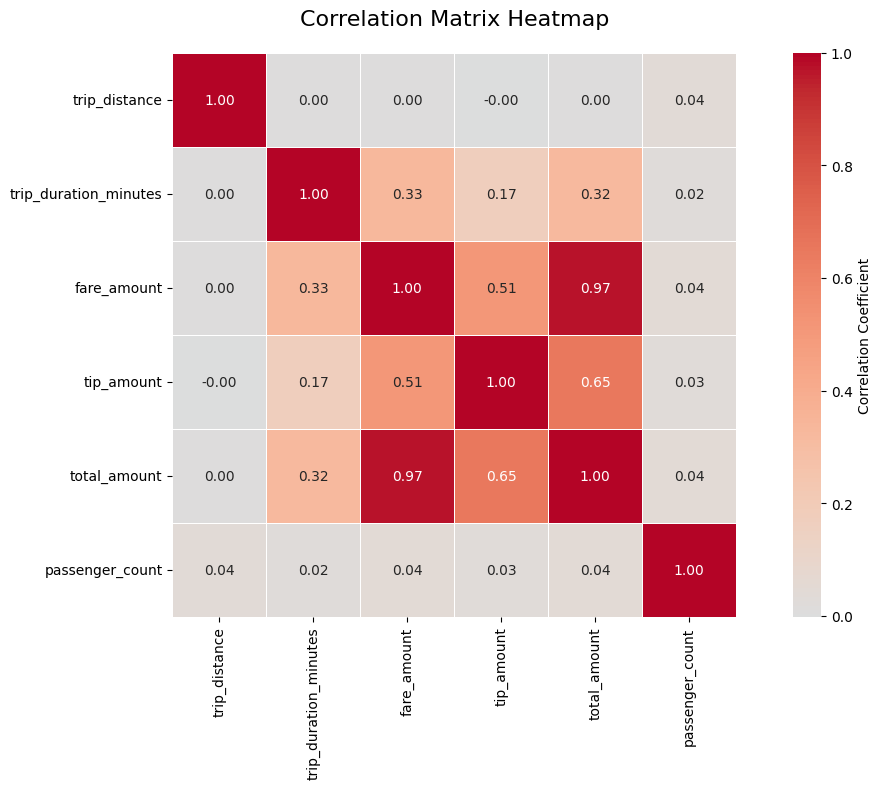

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check if corr_matrix exists, if not create it
try:
    _ = corr_matrix
except NameError:
    # Create correlation matrix if it doesn't exist
    correlation_cols = ['trip_distance', 'trip_duration_minutes', 'fare_amount',
                        'tip_amount', 'total_amount', 'passenger_count']
    try:
        _ = sept_yellow_df
    except NameError:
        sept_yellow_df = sept_yellow_df.copy()._to_pandas()
    corr_matrix = sept_yellow_df[correlation_cols].corr()

plt.figure(figsize=(12, 8))

sns.heatmap(corr_matrix,
            annot=True,
            cmap='coolwarm',
            center=0,
            fmt=".2f",
            square=True,
            linewidths=0.5,
            cbar_kws={"label": "Correlation Coefficient"})

plt.title("Correlation Matrix Heatmap", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Feature Engineering

## Negative Fare Indicators

In [26]:
# Step 1: Analyze patterns in negative fare values
print("=" * 80)
print("ANALYZING NEGATIVE FARE PATTERNS")
print("=" * 80)

# Create a subset of rows with negative fares for analysis
negative_fare_mask = sept_yellow_df['fare_amount'] < 0
negative_fare_df = sept_yellow_df[negative_fare_mask].copy()

print(f"\nTotal rows with negative fare: {negative_fare_mask.sum():,}")
print(f"\nPatterns in negative fare rows:")

# Check relationship with payment_type
print("\n1. Payment Type Distribution (Negative Fare Rows):")
print("-" * 80)
payment_neg_fare = negative_fare_df['payment_type'].value_counts().sort_index()
for ptype, count in payment_neg_fare.items():
    pct = count / len(negative_fare_df) * 100
    print(f"  Payment Type {ptype}: {count:,} ({pct:.2f}%)")

# Check relationship with zero distance (cancelled rides)
print("\n2. Zero Distance Trips (Potential Cancelled Rides):")
print("-" * 80)
zero_dist_neg_fare = (negative_fare_df['trip_distance'] == 0).sum()
print(f"  Negative fare + Zero distance: {zero_dist_neg_fare:,} ({zero_dist_neg_fare/len(negative_fare_df)*100:.2f}%)")

# Check magnitude of negative fares
print("\n3. Magnitude of Negative Fares:")
print("-" * 80)
print(f"  Mean negative fare: ${negative_fare_df['fare_amount'].mean():.2f}")
print(f"  Median negative fare: ${negative_fare_df['fare_amount'].median():.2f}")
print(f"  Max negative fare: ${negative_fare_df['fare_amount'].min():.2f}")
print(f"  Min negative fare: ${negative_fare_df['fare_amount'].max():.2f}")

# Check if total_amount is also negative (full refund)
print("\n4. Total Amount Patterns:")
print("-" * 80)
neg_total_neg_fare = (negative_fare_df['total_amount'] < 0).sum()
print(f"  Negative fare + Negative total: {neg_total_neg_fare:,} ({neg_total_neg_fare/len(negative_fare_df)*100:.2f}%)")

# Check relationship with other negative fields
print("\n5. Other Negative Fields in Negative Fare Rows:")
print("-" * 80)
for col in ['extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
            'congestion_surcharge', 'Airport_fee', 'cbd_congestion_fee']:
    neg_count = (negative_fare_df[col] < 0).sum()
    if neg_count > 0:
        print(f"  {col}: {neg_count:,} negative ({neg_count/len(negative_fare_df)*100:.2f}%)")


ANALYZING NEGATIVE FARE PATTERNS

Total rows with negative fare: 56,099

Patterns in negative fare rows:

1. Payment Type Distribution (Negative Fare Rows):
--------------------------------------------------------------------------------
  Payment Type 0: 41,124 (73.31%)
  Payment Type 1: 8 (0.01%)
  Payment Type 2: 3,403 (6.07%)
  Payment Type 3: 1,841 (3.28%)
  Payment Type 4: 9,723 (17.33%)

2. Zero Distance Trips (Potential Cancelled Rides):
--------------------------------------------------------------------------------
  Negative fare + Zero distance: 5,205 (9.28%)

3. Magnitude of Negative Fares:
--------------------------------------------------------------------------------
  Mean negative fare: $-10.14
  Median negative fare: $-4.75
  Max negative fare: $-998.00
  Min negative fare: $-0.10

4. Total Amount Patterns:
--------------------------------------------------------------------------------
  Negative fare + Negative total: 14,979 (26.70%)

5. Other Negative Fields in Ne

In [27]:
## Feature Engineering: Create Negative Fare Indicator Features

# Feature 1: Basic negative fare indicator
sept_yellow_df['has_negative_fare'] = (sept_yellow_df['fare_amount'] < 0).astype(int)
print(f"\nCreated 'has_negative_fare': {sept_yellow_df['has_negative_fare'].sum():,} trips")

# Feature 2: Cancelled ride indicator (negative fare + zero distance)
sept_yellow_df['is_cancelled_ride'] = (
    (sept_yellow_df['fare_amount'] < 0) &
    (sept_yellow_df['trip_distance'] == 0)
).astype(int)
print(f"Created 'is_cancelled_ride': {sept_yellow_df['is_cancelled_ride'].sum():,} trips")

# Feature 3: Full refund indicator (negative fare + negative total amount)
sept_yellow_df['is_full_refund'] = (
    (sept_yellow_df['fare_amount'] < 0) &
    (sept_yellow_df['total_amount'] < 0)
).astype(int)
print(f"Created 'is_full_refund': {sept_yellow_df['is_full_refund'].sum():,} trips")

# Feature 4: Partial adjustment indicator (negative fare but positive total)
sept_yellow_df['is_partial_adjustment'] = (
    (sept_yellow_df['fare_amount'] < 0) &
    (sept_yellow_df['total_amount'] >= 0)
).astype(int)
print(f"Created 'is_partial_adjustment': {sept_yellow_df['is_partial_adjustment'].sum():,} trips")

# Feature 5: Large negative fare indicator (refund > $50, likely significant refund)
sept_yellow_df['is_large_refund'] = (
    (sept_yellow_df['fare_amount'] < -50)
).astype(int)
print(f"Created 'is_large_refund': {sept_yellow_df['is_large_refund'].sum():,} trips")

# Feature 6: Small negative fare indicator (likely adjustment < $10)
sept_yellow_df['is_small_adjustment'] = (
    (sept_yellow_df['fare_amount'] < 0) &
    (sept_yellow_df['fare_amount'] > -10)
).astype(int)
print(f"Created 'is_small_adjustment': {sept_yellow_df['is_small_adjustment'].sum():,} trips")

# Feature 7: Negative fare with payment_type 0 (voided trip)
sept_yellow_df['is_voided_trip'] = (
    (sept_yellow_df['fare_amount'] < 0) &
    (sept_yellow_df['payment_type'] == 0)
).astype(int)
print(f"Created 'is_voided_trip': {sept_yellow_df['is_voided_trip'].sum():,} trips")

# Feature 8: Negative fare with other negative charges (complex refund)
sept_yellow_df['has_multiple_negative_charges'] = (
    (sept_yellow_df['fare_amount'] < 0) &
    (
        (sept_yellow_df['extra'] < 0) |
        (sept_yellow_df['mta_tax'] < 0) |
        (sept_yellow_df['tip_amount'] < 0) |
        (sept_yellow_df['tolls_amount'] < 0) |
        (sept_yellow_df['improvement_surcharge'] < 0) |
        (sept_yellow_df['congestion_surcharge'] < 0) |
        (sept_yellow_df['Airport_fee'] < 0) |
        (sept_yellow_df['cbd_congestion_fee'] < 0)
    )
).astype(int)
print(f"Created 'has_multiple_negative_charges': {sept_yellow_df['has_multiple_negative_charges'].sum():,} trips")

# Feature 9: Refund/adjustment category (categorical feature)
def categorize_negative_fare(row):
    """Categorize negative fare scenarios"""
    if row['fare_amount'] >= 0:
        return 'normal'
    elif row['trip_distance'] == 0:
        return 'cancelled'
    elif row['total_amount'] < 0:
        return 'full_refund'
    elif row['fare_amount'] < -50:
        return 'large_refund'
    elif row['fare_amount'] > -10:
        return 'small_adjustment'
    elif row['payment_type'] == 0:
        return 'voided'
    else:
        return 'partial_adjustment'

sept_yellow_df['negative_fare_category'] = sept_yellow_df.apply(categorize_negative_fare, axis=1)
print(f"Created 'negative_fare_category'")
print(f"\n  Distribution:")
print(sept_yellow_df['negative_fare_category'].value_counts())

# Feature 10: Absolute value of negative fare (for modeling)
sept_yellow_df['abs_negative_fare'] = sept_yellow_df['fare_amount'].apply(
    lambda x: abs(x) if x < 0 else 0
)
print(f"\nCreated 'abs_negative_fare' (absolute value of negative fares)")

# Feature 11: Refund/adjustment amount (negative values as positive for easier interpretation)
sept_yellow_df['refund_amount'] = sept_yellow_df['fare_amount'].apply(
    lambda x: abs(x) if x < 0 else 0
)
print(f"Created 'refund_amount' (refund amount as positive value)")



Created 'has_negative_fare': 56,099 trips
Created 'is_cancelled_ride': 5,205 trips
Created 'is_full_refund': 14,979 trips
Created 'is_partial_adjustment': 41,120 trips
Created 'is_large_refund': 2,320 trips
Created 'is_small_adjustment': 44,613 trips
Created 'is_voided_trip': 41,124 trips
Created 'has_multiple_negative_charges': 14,980 trips
Created 'negative_fare_category'

  Distribution:
negative_fare_category
normal              800612
small_adjustment     35649
full_refund          13947
cancelled             5205
voided                1297
large_refund             1
Name: count, dtype: int64

Created 'abs_negative_fare' (absolute value of negative fares)
Created 'refund_amount' (refund amount as positive value)


In [28]:
## Summary: Negative Fare Feature Analysis

print("\n" + "=" * 80)
print("NEGATIVE FARE FEATURE SUMMARY")
print("=" * 80)

# Summary statistics
summary_stats = {
    'Total trips': len(sept_yellow_df),
    'Trips with negative fare': sept_yellow_df['has_negative_fare'].sum(),
    'Cancelled rides (neg fare + zero dist)': sept_yellow_df['is_cancelled_ride'].sum(),
    'Full refunds (neg fare + neg total)': sept_yellow_df['is_full_refund'].sum(),
    'Partial adjustments (neg fare + pos total)': sept_yellow_df['is_partial_adjustment'].sum(),
    'Large refunds (>$50)': sept_yellow_df['is_large_refund'].sum(),
    'Small adjustments (<$10)': sept_yellow_df['is_small_adjustment'].sum(),
    'Voided trips (neg fare + payment_type 0)': sept_yellow_df['is_voided_trip'].sum(),
    'Multiple negative charges': sept_yellow_df['has_multiple_negative_charges'].sum()
}

print("\nFeature Counts:")
print("-" * 80)
for feature, count in summary_stats.items():
    pct = (count / len(sept_yellow_df)) * 100
    print(f"  {feature}: {count:,} ({pct:.2f}%)")

# Overlap analysis
print("\n\nOverlap Analysis (Negative Fare Categories):")
print("-" * 80)
neg_fare_subset = sept_yellow_df[sept_yellow_df['has_negative_fare'] == 1]
print(f"\nTotal negative fare trips: {len(neg_fare_subset):,}")
print(f"\nBreakdown by category:")
category_breakdown = neg_fare_subset['negative_fare_category'].value_counts()
for category, count in category_breakdown.items():
    pct = count / len(neg_fare_subset) * 100
    print(f"  {category}: {count:,} ({pct:.2f}%)")

# Statistics on refund amounts
print("\n\nRefund Amount Statistics:")
print("-" * 80)
refund_subset = sept_yellow_df[sept_yellow_df['refund_amount'] > 0]
if len(refund_subset) > 0:
    print(f"  Mean refund amount: ${refund_subset['refund_amount'].mean():.2f}")
    print(f"  Median refund amount: ${refund_subset['refund_amount'].median():.2f}")
    print(f"  Min refund amount: ${refund_subset['refund_amount'].min():.2f}")
    print(f"  Max refund amount: ${refund_subset['refund_amount'].max():.2f}")
    print(f"  Total refund amount: ${refund_subset['refund_amount'].sum():,.2f}")

print("\n" + "=" * 80)



NEGATIVE FARE FEATURE SUMMARY

Feature Counts:
--------------------------------------------------------------------------------
  Total trips: 856,711 (100.00%)
  Trips with negative fare: 56,099 (6.55%)
  Cancelled rides (neg fare + zero dist): 5,205 (0.61%)
  Full refunds (neg fare + neg total): 14,979 (1.75%)
  Partial adjustments (neg fare + pos total): 41,120 (4.80%)
  Large refunds (>$50): 2,320 (0.27%)
  Small adjustments (<$10): 44,613 (5.21%)
  Voided trips (neg fare + payment_type 0): 41,124 (4.80%)
  Multiple negative charges: 14,980 (1.75%)


Overlap Analysis (Negative Fare Categories):
--------------------------------------------------------------------------------

Total negative fare trips: 56,099

Breakdown by category:
  small_adjustment: 35,649 (63.55%)
  full_refund: 13,947 (24.86%)
  cancelled: 5,205 (9.28%)
  voided: 1,297 (2.31%)
  large_refund: 1 (0.00%)


Refund Amount Statistics:
--------------------------------------------------------------------------------


## Additional Features

In [29]:
# Create Additional Features for Model Training

print("=" * 80)
print("CREATING ADDITIONAL FEATURES")
print("=" * 80)

# Ensure temporal features exist
if 'pickup_hour' not in sept_yellow_df.columns:
    sept_yellow_df['pickup_hour'] = sept_yellow_df['tpep_pickup_datetime'].dt.hour
    sept_yellow_df['pickup_dayofweek'] = sept_yellow_df['tpep_pickup_datetime'].dt.dayofweek
    sept_yellow_df['pickup_month'] = sept_yellow_df['tpep_pickup_datetime'].dt.month
    sept_yellow_df['pickup_day'] = sept_yellow_df['tpep_pickup_datetime'].dt.day

if 'trip_duration_minutes' not in sept_yellow_df.columns:
    sept_yellow_df['trip_duration_minutes'] = (
        (sept_yellow_df['tpep_dropoff_datetime'] - sept_yellow_df['tpep_pickup_datetime']).dt.total_seconds() / 60
    )

# 1. Time-based Features
print("\n1. Time-based Features:")
print("-" * 80)

# Weekend indicator
sept_yellow_df['is_weekend'] = (sept_yellow_df['pickup_dayofweek'] >= 5).astype(int)
print(f"Created 'is_weekend': {sept_yellow_df['is_weekend'].sum():,} trips")

# Rush hour indicator (7-9 AM and 5-7 PM)
sept_yellow_df['is_rush_hour'] = sept_yellow_df['pickup_hour'].apply(
    lambda x: 1 if (x >= 7 and x <= 9) or (x >= 17 and x <= 19) else 0
)
print(f"Created 'is_rush_hour': {sept_yellow_df['is_rush_hour'].sum():,} trips")

# Night time indicator (10 PM - 5 AM)
sept_yellow_df['is_night'] = sept_yellow_df['pickup_hour'].apply(
    lambda x: 1 if x >= 22 or x <= 5 else 0
)
print(f"Created 'is_night': {sept_yellow_df['is_night'].sum():,} trips")

# Morning (6-11 AM), Afternoon (12-16), Evening (17-21), Late Night (22-5)
sept_yellow_df['time_of_day'] = sept_yellow_df['pickup_hour'].apply(
    lambda x: 'morning' if 6 <= x <= 11
    else 'afternoon' if 12 <= x <= 16
    else 'evening' if 17 <= x <= 21
    else 'late_night'
)
print(f"Created 'time_of_day' categorical feature")

# 2. Location-based Features
print("\n2. Location-based Features:")
print("-" * 80)

# Same pickup and dropoff location
sept_yellow_df['same_pickup_dropoff'] = (
    sept_yellow_df['PULocationID'] == sept_yellow_df['DOLocationID']
).astype(int)
print(f"Created 'same_pickup_dropoff': {sept_yellow_df['same_pickup_dropoff'].sum():,} trips")

# Frequency encoding for locations (popularity of pickup/dropoff locations)
def frequency_encode(df, col):
    """Create frequency encoding for a column"""
    freq_map = df[col].value_counts().to_dict()
    df[f'{col}_freq'] = df[col].map(freq_map)
    return df

sept_yellow_df = frequency_encode(sept_yellow_df, 'PULocationID')
sept_yellow_df = frequency_encode(sept_yellow_df, 'DOLocationID')
print(f"Created 'PULocationID_freq' and 'DOLocationID_freq' for (EDA Only)")

# 3. Financial Features
print("\n3. Financial Features:")
print("-" * 80)

# Tip percentage (only for trips with fare > 0)
sept_yellow_df['tip_percentage'] = (
    (sept_yellow_df['tip_amount'] / sept_yellow_df['fare_amount'] * 100)
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0)
    .clip(0, 100)  # Cap at 100%
)
print(f"Created 'tip_percentage'")

# Fare per mile (only for trips with distance > 0)
sept_yellow_df['fare_per_mile'] = (
    (sept_yellow_df['fare_amount'] / sept_yellow_df['trip_distance'])
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0)
)
print(f"Created 'fare_per_mile'")

# Total charges breakdown
sept_yellow_df['total_charges'] = (
    sept_yellow_df['fare_amount'] +
    sept_yellow_df['extra'] +
    sept_yellow_df['mta_tax'] +
    sept_yellow_df['improvement_surcharge'] +
    sept_yellow_df['congestion_surcharge'].fillna(0) +
    sept_yellow_df['Airport_fee'].fillna(0) +
    sept_yellow_df['cbd_congestion_fee'].fillna(0)
)
print(f"Created 'total_charges' (sum of all charges)")

# Tip ratio (tip / total_amount)
sept_yellow_df['tip_ratio'] = (
    (sept_yellow_df['tip_amount'] / sept_yellow_df['total_amount'])
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0)
    .clip(0, 1)
)
print(f"Created 'tip_ratio'")

# 4. Trip Efficiency Features
print("\n4. Trip Efficiency Features:")
print("-" * 80)

# Speed (miles per hour) - cap unrealistic speeds
if 'speed_mph' not in sept_yellow_df.columns:
    sept_yellow_df['speed_mph'] = (
        (sept_yellow_df['trip_distance'] / (sept_yellow_df['trip_duration_minutes'] / 60))
        .replace([np.inf, -np.inf], np.nan)
    )
sept_yellow_df['speed_mph'] = sept_yellow_df['speed_mph'].clip(0, 80)
print(f"Created/updated 'speed_mph' (capped at 80 mph)")

# Distance per minute
sept_yellow_df['distance_per_minute'] = (
    (sept_yellow_df['trip_distance'] / sept_yellow_df['trip_duration_minutes'])
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0)
)
print(f"Created 'distance_per_minute'")

# Revenue per mile (if not already created)
if 'revenue_per_mile' not in sept_yellow_df.columns:
    sept_yellow_df['revenue_per_mile'] = (
        (sept_yellow_df['total_amount'] / sept_yellow_df['trip_distance'])
        .replace([np.inf, -np.inf], np.nan)
        .fillna(0)
    )
print(f"Created/updated 'revenue_per_mile'")

# 5. Passenger Features
print("\n5. Passenger Features:")
print("-" * 80)

# Passenger count (fill missing with mode)
if sept_yellow_df['passenger_count'].isnull().sum() > 0:
    mode_passenger = sept_yellow_df['passenger_count'].mode()[0] if len(sept_yellow_df['passenger_count'].mode()) > 0 else 1
    sept_yellow_df['passenger_count'] = sept_yellow_df['passenger_count'].fillna(mode_passenger)
print(f"Handled missing 'passenger_count'")

# Passenger per mile (efficiency metric)
sept_yellow_df['passengers_per_mile'] = (
    (sept_yellow_df['passenger_count'] / sept_yellow_df['trip_distance'])
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0)
)
print(f"Created 'passengers_per_mile'")

# 6. Vendor and Payment Features
print("\n6. Vendor and Payment Features:")
print("-" * 80)

# Vendor-Payment interaction
sept_yellow_df['vendor_payment_interaction'] = (
    sept_yellow_df['VendorID'].astype(str) + '_' +
    sept_yellow_df['payment_type'].astype(str)
)
print(f"Created 'vendor_payment_interaction'")

# 7. Temporal Cyclical Features (for better time representation)
print("\n7. Cyclical Time Features:")
print("-" * 80)

# Cyclical encoding for hour (0-23) - helps model understand time continuity
sept_yellow_df['hour_sin'] = np.sin(2 * np.pi * sept_yellow_df['pickup_hour'] / 24)
sept_yellow_df['hour_cos'] = np.cos(2 * np.pi * sept_yellow_df['pickup_hour'] / 24)
print(f"Created 'hour_sin' and 'hour_cos' (cyclical hour encoding)")

# Cyclical encoding for day of week (0-6)
sept_yellow_df['dayofweek_sin'] = np.sin(2 * np.pi * sept_yellow_df['pickup_dayofweek'] / 7)
sept_yellow_df['dayofweek_cos'] = np.cos(2 * np.pi * sept_yellow_df['pickup_dayofweek'] / 7)
print(f"Created 'dayofweek_sin' and 'dayofweek_cos' (cyclical day encoding)")

# Cyclical encoding for day of month (1-31)
sept_yellow_df['day_sin'] = np.sin(2 * np.pi * sept_yellow_df['pickup_day'] / 31)
sept_yellow_df['day_cos'] = np.cos(2 * np.pi * sept_yellow_df['pickup_day'] / 31)
print(f"Created 'day_sin' and 'day_cos' (cyclical day of month encoding)")

print("\n" + "=" * 80)
print("ADDITIONAL FEATURE ENGINEERING COMPLETE")
print("=" * 80)
print(f"\nTotal features created: {len([col for col in sept_yellow_df.columns if col not in ['tpep_pickup_datetime', 'tpep_dropoff_datetime']])}")


CREATING ADDITIONAL FEATURES

1. Time-based Features:
--------------------------------------------------------------------------------
Created 'is_weekend': 228,250 trips
Created 'is_rush_hour': 268,487 trips
Created 'is_night': 166,374 trips
Created 'time_of_day' categorical feature

2. Location-based Features:
--------------------------------------------------------------------------------
Created 'same_pickup_dropoff': 37,432 trips
Created 'PULocationID_freq' and 'DOLocationID_freq' for (EDA Only)

3. Financial Features:
--------------------------------------------------------------------------------
Created 'tip_percentage'
Created 'fare_per_mile'
Created 'total_charges' (sum of all charges)
Created 'tip_ratio'

4. Trip Efficiency Features:
--------------------------------------------------------------------------------
Created/updated 'speed_mph' (capped at 80 mph)
Created 'distance_per_minute'
Created/updated 'revenue_per_mile'

5. Passenger Features:
----------------------------

In [30]:
# Analyze Feature Usefulness

print("=" * 80)
print("FEATURE USEFULNESS ANALYSIS")
print("=" * 80)

# Convert to pandas for easier analysis
import pandas as pandas_lib

# Select numerical features to analyze
numerical_features = [
    # Original features
    'trip_distance', 'fare_amount', 'total_amount', 'tip_amount',
    'trip_duration_minutes', 'passenger_count', 'tolls_amount',

    # Temporal features
    'pickup_hour', 'pickup_dayofweek', 'pickup_month',
    'is_weekend', 'is_rush_hour', 'is_night',
    'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos',

    # Location features
    'PULocationID', 'DOLocationID', 'PULocationID_freq', 'DOLocationID_freq',
    'same_pickup_dropoff',

    # Financial features
    'tip_percentage', 'fare_per_mile', 'total_charges', 'tip_ratio',
    'revenue_per_mile', 'refund_amount',

    # Efficiency features
    'speed_mph', 'distance_per_minute', 'passengers_per_mile',

    # Negative fare indicators
    'has_negative_fare', 'is_cancelled_ride', 'is_full_refund',
    'is_partial_adjustment', 'is_large_refund', 'is_small_adjustment',
    'is_voided_trip', 'has_multiple_negative_charges'
]

# Filter to only features that exist
available_features = [f for f in numerical_features if f in sept_yellow_df.columns]

print(f"\nAnalyzing {len(available_features)} numerical features...")

# 1. Correlation with target variables (assuming total_amount or fare_amount as target)
print("\n1. Correlation Analysis with Target Variables:")
print("-" * 80)

target_vars = ['total_amount', 'fare_amount', 'tip_amount']
for target in target_vars:
    if target in sept_yellow_df.columns and target in available_features:
        print(f"\nCorrelation with {target}:")
        try:
            # Get correlation matrix
            feature_cols = [f for f in available_features if f != target] + [target]
            corr_matrix = sept_yellow_df[feature_cols].corr()

            # Extract correlations with target as a Series
            if target in corr_matrix.columns:
                correlations_series = corr_matrix[target]
                # Remove target itself
                correlations_series = correlations_series.drop(target)

                # Convert to DataFrame for easier sorting
                correlations_df = pandas_lib.DataFrame({
                    'feature': correlations_series.index,
                    'correlation': correlations_series.values
                })
                # Sort by correlation value
                correlations_df = correlations_df.sort_values('correlation', ascending=False)

                # Show top 15 positive correlations
                top_features = correlations_df[correlations_df['correlation'] > 0].head(15)
                print("\nTop 15 Positive Correlations:")
                for _, row in top_features.iterrows():
                    print(f"  {row['feature']:30s}: {row['correlation']:7.4f}")

                # Show top 10 negative correlations
                bottom_features = correlations_df[correlations_df['correlation'] < 0].tail(10)
                print("\nTop 10 Negative Correlations:")
                for _, row in bottom_features.iterrows():
                    print(f"  {row['feature']:30s}: {row['correlation']:7.4f}")
        except Exception as e:
            print(f"  Error calculating correlations: {e}")

# 2. Feature Variance Analysis (low variance = less useful)
print("\n\n2. Feature Variance Analysis (Low Variance Features):")
print("-" * 80)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
feature_data = sept_yellow_df[available_features].fillna(0)
scaled_data = scaler.fit_transform(feature_data)
feature_variances = pd.DataFrame({
    'feature': available_features,
    'variance': np.var(scaled_data, axis=0)
}).sort_values('variance')

print("\nFeatures with lowest variance (may be less useful):")
print(feature_variances.head(10))

print("\nFeatures with highest variance (may be more useful):")
print(feature_variances.tail(10))

# 3. Missing Value Analysis
print("\n\n3. Missing Value Analysis:")
print("-" * 80)
missing_analysis = pd.DataFrame({
    'feature': available_features,
    'missing_count': [sept_yellow_df[f].isnull().sum() for f in available_features],
    'missing_pct': [sept_yellow_df[f].isnull().sum() / len(sept_yellow_df) * 100 for f in available_features]
}).sort_values('missing_pct', ascending=False)

print("\nFeatures with missing values:")
print(missing_analysis[missing_analysis['missing_count'] > 0].head(10))

# 4. Feature Distribution Analysis (check for constant or near-constant features)
print("\n\n4. Constant/Near-Constant Features:")
print("-" * 80)
constant_features = []
for feat in available_features:
    unique_vals = sept_yellow_df[feat].nunique()
    if unique_vals <= 1:
        constant_features.append(feat)
    elif unique_vals == 2:
        # Check if one value dominates (>99%)
        value_counts = sept_yellow_df[feat].value_counts(normalize=True)
        if value_counts.max() > 0.99:
            constant_features.append(feat)

if constant_features:
    print(f"Found {len(constant_features)} constant/near-constant features:")
    for feat in constant_features:
        print(f"  - {feat}")
else:
    print("No constant features found ✓")

# 5. Feature Importance using Random Forest (if we have a target)
print("\n\n5. Feature Importance Analysis (using ):")
print("-" * 80)

# Use total_amount as target for demonstration
if 'total_amount' in sept_yellow_df.columns:
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import train_test_split

    # Prepare data
    X = sept_yellow_df[available_features].fillna(0)
    y = sept_yellow_df['total_amount']

    # Remove infinite values
    X = X.replace([np.inf, -np.inf], 0)

    # Sample data if too large (for faster computation)
    if len(X) > 100000:
        X_sample, _, y_sample, _ = train_test_split(X, y, train_size=100000, random_state=42)
    else:
        X_sample, y_sample = X, y

    # Train a simple Random Forest
    print("Training Random Forest for feature importance...")
    rf = RandomForestRegressor(n_estimators=100, max_depth=50, random_state=42, n_jobs=-1)
    rf.fit(X_sample, y_sample)

    # Get feature importances
    feature_importance = pd.DataFrame({
        'feature': available_features,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nTop 20 Most Important Features:")
    print(feature_importance.head(20))

    print("\nBottom 10 Least Important Features:")
    print(feature_importance.tail(10))


FEATURE USEFULNESS ANALYSIS

Analyzing 39 numerical features...

1. Correlation Analysis with Target Variables:
--------------------------------------------------------------------------------

Correlation with total_amount:

Top 15 Positive Correlations:
  total_charges                 :  0.9821
  fare_amount                   :  0.9734
  tip_amount                    :  0.6508
  tolls_amount                  :  0.6049
  speed_mph                     :  0.3789
  trip_duration_minutes         :  0.3230
  tip_ratio                     :  0.1797
  PULocationID_freq             :  0.1031
  fare_per_mile                 :  0.0856
  tip_percentage                :  0.0825
  revenue_per_mile              :  0.0794
  passenger_count               :  0.0625
  dayofweek_sin                 :  0.0151
  pickup_hour                   :  0.0139
  trip_distance                 :  0.0025

Top 10 Negative Correlations:
  is_cancelled_ride             : -0.0996
  DOLocationID_freq             : -0.1835

In [31]:
# Feature Selection Recommendations

# Create a comprehensive feature evaluation summary

# Define all potential features
all_features = {
    # Core features (keep)
    'core': ['trip_distance', 'trip_duration_minutes', 'passenger_count',
             'fare_amount', 'total_amount', 'tip_amount', 'tolls_amount'],

    # Temporal features (keep - high value)
    'temporal': ['pickup_hour', 'pickup_dayofweek', 'pickup_month',
                 'is_weekend', 'is_rush_hour', 'is_night',
                 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos'],

    # Location features (keep - important for taxi data)
    'location': ['PULocationID', 'DOLocationID', 'PULocationID_freq',
                 'DOLocationID_freq', 'same_pickup_dropoff'],

    # Financial features (keep - directly related to target)
    'financial': ['tip_percentage', 'fare_per_mile', 'total_charges',
                   'tip_ratio', 'revenue_per_mile'],

    # Efficiency features (evaluate - may be redundant)
    'efficiency': ['speed_mph', 'distance_per_minute', 'passengers_per_mile'],

    # Negative fare indicators (keep - important for data quality)
    'negative_fare': ['has_negative_fare', 'is_cancelled_ride', 'is_full_refund',
                      'is_partial_adjustment', 'is_voided_trip', 'refund_amount'],

    # Categorical features (need encoding)
    'categorical': ['VendorID', 'payment_type', 'RatecodeID',
                   'store_and_fwd_flag', 'time_of_day', 'negative_fare_category']
}

print("\nFeature Categories and Recommendations:")
print("-" * 80)

for category, features in all_features.items():
    existing = [f for f in features if f in sept_yellow_df.columns]
    print(f"\n{category.upper()} Features ({len(existing)}/{len(features)} exist):")
    for feat in existing:
        # Check if feature exists and has data
        if feat in sept_yellow_df.columns:
            missing_pct = sept_yellow_df[feat].isnull().sum() / len(sept_yellow_df) * 100
            unique_vals = sept_yellow_df[feat].nunique()
            print(f"  {feat:30s} (missing: {missing_pct:5.2f}%, unique: {unique_vals})")



Feature Categories and Recommendations:
--------------------------------------------------------------------------------

CORE Features (7/7 exist):
  trip_distance                  (missing:  0.00%, unique: 3663)
  trip_duration_minutes          (missing:  0.00%, unique: 7248)
  passenger_count                (missing:  0.00%, unique: 8)
  fare_amount                    (missing:  0.00%, unique: 8275)
  total_amount                   (missing:  0.00%, unique: 15323)
  tip_amount                     (missing:  0.00%, unique: 3249)
  tolls_amount                   (missing:  0.00%, unique: 576)

TEMPORAL Features (10/10 exist):
  pickup_hour                    (missing:  0.00%, unique: 24)
  pickup_dayofweek               (missing:  0.00%, unique: 7)
  pickup_month                   (missing:  0.00%, unique: 2)
  is_weekend                     (missing:  0.00%, unique: 2)
  is_rush_hour                   (missing:  0.00%, unique: 2)
  is_night                       (missing:  0.00%, un

# Preprocessing Pipeline for Model Training

In [32]:
# Import required libraries for preprocessing pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

# Custom Transformer: Cap Outliers
class OutlierCapper(BaseEstimator, TransformerMixin):
    """Cap outliers at specified percentiles"""
    def __init__(self, lower_percentile=0.01, upper_percentile=0.99):
        self.lower_percentile = lower_percentile
        self.upper_percentile = upper_percentile
        self.lower_bounds_ = {}
        self.upper_bounds_ = {}

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            for col in X.columns:
                self.lower_bounds_[col] = X[col].quantile(self.lower_percentile)
                self.upper_bounds_[col] = X[col].quantile(self.upper_percentile)
        else:
            # If numpy array, assume columns are in order
            for i in range(X.shape[1]):
                self.lower_bounds_[i] = np.quantile(X[:, i], self.lower_percentile)
                self.upper_bounds_[i] = np.quantile(X[:, i], self.upper_percentile)
        return self

    def transform(self, X):
        X = X.copy()
        if isinstance(X, pd.DataFrame):
            for col in X.columns:
                if col in self.lower_bounds_:
                    X[col] = X[col].clip(
                        lower=self.lower_bounds_[col],
                        upper=self.upper_bounds_[col]
                    )
        else:
            for i in range(X.shape[1]):
                if i in self.lower_bounds_:
                    X[:, i] = np.clip(
                        X[:, i],
                        self.lower_bounds_[i],
                        self.upper_bounds_[i]
                    )
        return X

# Custom Transformer: Handle MNAR Missing Values
class MNARHandler(BaseEstimator, TransformerMixin):
    """Replace missing values with 'MISSING' string for categorical, -999 for numerical"""
    def __init__(self, missing_value_cat='MISSING', add_numeric_indicator=True):
        self.missing_value_cat = missing_value_cat
        self.add_numeric_indicator = add_numeric_indicator
        self.categorical_cols_ = []
        self.numerical_cols_ = []
        self.numeric_medians_ = {}

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            self.categorical_cols_ = X.select_dtypes(include=['object', 'category']).columns.tolist()
            self.numerical_cols_ = X.select_dtypes(include=[np.number]).columns.tolist()
            # computing median for numerical columns
            for col in self.numerical_cols_:
                self.numeric_medians_[col] = X[col].median()
        return self

    def transform(self, X):
        X = X.copy()
        if isinstance(X, pd.DataFrame):
            # Handle categorical columns
            for col in self.categorical_cols_:
                if col in X.columns:
                    X[col] = X[col].fillna(self.missing_value_cat)
            # Handle numerical columns
            for col in self.numerical_cols_:
                if col in X.columns:
                    if self.add_numeric_indicator:
                        indicator_col = f"{col}_is_missing"
                        X[indicator_col] = X[col].isnull().astype(int)
                    median_val = self.numeric_medians_.get(col, 0.0)
                    X[col] = X[col].fillna(median_val)
        return X

# Custom Transformer: Handle Zero/Invalid Values (Option B - Flag them)
class ZeroInvalidHandler(BaseEstimator, TransformerMixin):
    """Flag zero/invalid values but keep original values"""
    def __init__(self):
        self.zero_cols_ = []

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            # Identify columns that should be non-zero
            potential_zero_cols = ['trip_distance', 'trip_duration_minutes', 'fare_amount']
            self.zero_cols_ = [col for col in potential_zero_cols if col in X.columns]
        return self

    def transform(self, X):
        X = X.copy()
        if isinstance(X, pd.DataFrame):
            for col in self.zero_cols_:
                if col in X.columns:
                    # Create flag for zero/invalid values
                    flag_col = f'{col}_is_zero'
                    X[flag_col] = (X[col] <= 0).astype(int)
        return X

class LocationFrequencyEncoder(BaseEstimator, TransformerMixin):
    """
    Frequency encode high-cardinality location IDs (eg: PULocationID, DOLocationID)
    
    - During Fit: compute value_counts only on training data
    - During Transform: map IDs to frequencies; unseen values -> 0
    """
    def __init__(self, columns=("PULocationID", "DOLocationID")):
        self.columns = columns
        self.freq_maps_ = {}

    def fit(self, X, y=None):
        X_df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        

        for col in self.columns:
            if col in X_df.columns:
                freq = X_df[col].value_counts(dropna=False).to_dict()
                self.freq_maps_[col] = freq
        return self

    def transform(self, X):
        X_df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X).copy()
        for col, freq_map in self.freq_maps_.items():
            if col in X_df.columns:
                freq_col = f"{col}_freq"
                X_df[freq_col] = X_df[col].map(freq_map).fillna(0)
        return X_df

In [33]:
# Define feature categories
numerical_features = [
    # Core features
    'trip_distance', 'trip_duration_minutes', 'passenger_count',
    'fare_amount', 'tip_amount', 'tolls_amount',

    # Derived financial features
    'fare_per_mile', 'revenue_per_mile', 'tip_percentage',

    # Efficiency features
    'speed_mph',

    # Temporal features
    'pickup_hour', 'pickup_dayofweek', 'pickup_month',
    'is_weekend', 'is_rush_hour', 'is_night',
    'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos',

    # Negative fare indicators (Option C - keep negatives)
    'refund_amount', 'has_negative_fare', 'is_full_refund',

    # Zero/invalid flags (will be created before pipeline)
    # Note: These will be added to the dataframe before preprocessing
]

categorical_features = [
    'VendorID', 'payment_type', 'RatecodeID',
    'store_and_fwd_flag', 'time_of_day', 'negative_fare_category',
    'vendor_payment_interaction'
]

# Filter to only features that exist
available_numerical = [f for f in numerical_features if f in sept_yellow_df.columns]
available_categorical = [f for f in categorical_features if f in sept_yellow_df.columns]

print(f"\nNumerical features ({len(available_numerical)}):")
for feat in available_numerical[:10]:  # Show first 10
    print(f"  - {feat}")
if len(available_numerical) > 10:
    print(f"  ... and {len(available_numerical) - 10} more")

print(f"\nCategorical features ({len(available_categorical)}):")
for feat in available_categorical:
    print(f"  - {feat}")

print(f"\nTotal features: {len(available_numerical) + len(available_categorical)}")



Numerical features (23):
  - trip_distance
  - trip_duration_minutes
  - passenger_count
  - fare_amount
  - tip_amount
  - tolls_amount
  - fare_per_mile
  - revenue_per_mile
  - tip_percentage
  - speed_mph
  ... and 13 more

Categorical features (7):
  - VendorID
  - payment_type
  - RatecodeID
  - store_and_fwd_flag
  - time_of_day
  - negative_fare_category
  - vendor_payment_interaction

Total features: 30


In [34]:
# Create the complete preprocessing pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor

# Reduced n_estimators and max_depth to save memory
base_regressor = RandomForestRegressor(
    n_estimators=50,  # Reduced from 200 to save memory
    max_depth=15,     # Limited depth to prevent excessive memory usage
    n_jobs=-1,
    random_state=42
)

log_rf = TransformedTargetRegressor(
    regressor=base_regressor,
    func=np.log1p,
    inverse_func=np.expm1
)
# Numerical features pipeline
numerical_pipeline = Pipeline([
    ('outlier_capper', OutlierCapper(lower_percentile=0.01, upper_percentile=0.99)),
    ('mnar_handler', MNARHandler(add_numeric_indicator=True)),
    ('scaler', RobustScaler())  # RobustScaler handles outliers better than StandardScaler
])

# Categorical features pipeline
# Using sparse_output=True to save memory (sklearn models support sparse matrices)
categorical_pipeline = Pipeline([
    ('mnar_handler', MNARHandler(missing_value_cat='MISSING', add_numeric_indicator=False)),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Pipeline will be created after zero flags are added to available_numerical
# This is done in the next cell

print("\n✓ Preprocessing pipeline created:")
print("\n  Numerical Features Pipeline:")
print("    1. OutlierCapper (cap at 1st-99th percentile)")
print("    2. MNARHandler (median impute + missing indicator for numerical features)")
print("    3. RobustScaler (scale features)")
print("\n  Categorical Features Pipeline:")
print("    1. MNARHandler (replace missing with 'MISSING')")
print("    2. OneHotEncoder (encode categories)")
print("    3. Logarithmic transformation (log1p) on target")

print(f"\n  Total features in pipeline:")
print(f"    - Numerical: {len(available_numerical)}")
print(f"    - Categorical: {len(available_categorical)}")

# Helper function to create zero/invalid flags (reusable)
def create_zero_flags(df, columns=['trip_distance', 'trip_duration_minutes', 'fare_amount'], 
                     numerical_feature_list=None):
    """
    Create zero/invalid flags for specified columns.
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe
    columns : list
        List of column names to create flags for
    numerical_feature_list : list, optional
        If provided, will append flag column names to this list
        
    Returns:
    --------
    zero_flag_cols : list
        List of created flag column names
    """
    zero_flag_cols = []
    for col in columns:
        if col in df.columns:
            flag_col = f'{col}_is_zero'
            
            df.loc[:, flag_col] = (df[col] <= 0).astype(int)
            zero_flag_cols.append(flag_col)
            if numerical_feature_list is not None:
                numerical_feature_list.append(flag_col)
    return zero_flag_cols

print("\nHelper function 'create_zero_flags' created")


✓ Preprocessing pipeline created:

  Numerical Features Pipeline:
    1. OutlierCapper (cap at 1st-99th percentile)
    2. MNARHandler (median impute + missing indicator for numerical features)
    3. RobustScaler (scale features)

  Categorical Features Pipeline:
    1. MNARHandler (replace missing with 'MISSING')
    2. OneHotEncoder (encode categories)
    3. Logarithmic transformation (log1p) on target

  Total features in pipeline:
    - Numerical: 23
    - Categorical: 7

Helper function 'create_zero_flags' created


In [35]:
def build_preprocessing_pipeline(numerical_features, categorical_features):
    """
    Build a Full Data Pre-processing Pipeline

    1. LocationFrequencyEncoder:
        - adds PULocationID_freq and DOLocationID_freq columns
    2. ColumnTransformer:
        - numerical pipeline on numerical_features + (any flags/indicators)
        - categorical pipeline on categorical_features

    Parameters:
    -----------
    numerical_features: list of str
        Names of numerical (and numeric-flags) features to include in pipeline.
    categorical_features: list of str
        Names of categorical features to include in pipeline.
    """
    freq_numeric_features = []

    if "PULocationID" in categorical_features or "PULocationID" in numerical_features:
        freq_numeric_features.append("PULocationID_freq")
    if "DOLocationID" in categorical_features or "DOLocationID" in numerical_features:
        freq_numeric_features.append("DOLocationID_freq")

    numerical_features_for_transformer = numerical_features + [
        col for col in freq_numeric_features if col not in numerical_features
    ]

    column_transformer = ColumnTransformer(
        transformers=[
            ('numerical', numerical_pipeline, numerical_features_for_transformer),
            ('categorical', categorical_pipeline, categorical_features),
        ],
        remainder='drop'
    )

    preprocessing_pipeline = Pipeline([
        ('freq_encoder', LocationFrequencyEncoder(columns=('PULocationID', 'DOLocationID'))),
        ('column_transformer', column_transformer),
    ])
    return preprocessing_pipeline

In [36]:
# Test the pipeline and prepare data for training

# Prepare the dataset
# Step 1: Create zero/invalid flags (Option B - keep but flag them)
print("\nCreating zero/invalid flags...")
# Create a copy of available_numerical to avoid modifying the original
numerical_with_flags = available_numerical.copy()
# Select features first (no copy needed if we're just selecting columns)
X_data = sept_yellow_df[numerical_with_flags + available_categorical].copy()

# Create flags for zero/invalid values using helper function
zero_flag_cols = create_zero_flags(X_data, numerical_feature_list=numerical_with_flags)
for flag_col in zero_flag_cols:
    print(f"Created {flag_col}!")

# Select all features including flags (copy only when needed for modification)
all_features = numerical_with_flags + available_categorical
X_data = X_data[all_features].copy()

# Building full preprocessing pipeline
print("\n" + "-" * 80)
preprocessing_pipeline = build_preprocessing_pipeline(numerical_with_flags, available_categorical)


print(f"\nOriginal data shape: {X_data.shape}")
print(f"Features: {X_data.columns.tolist()[:5]}... (showing first 5)")

# Check for missing values before preprocessing
print("\nMissing values before preprocessing:")
missing_before = X_data.isnull().sum()
missing_cols = missing_before[missing_before > 0]
if len(missing_cols) > 0:
    print(missing_cols.head(10))
else:
    print("  No missing values")

# Fit and transform the pipeline
print("\n" + "-" * 80)
print("Fitting preprocessing pipeline...")
preprocessing_pipeline.fit(X_data)
print("Pipeline fitted successfully!")

print("\nTransforming data...")
X_transformed = preprocessing_pipeline.transform(X_data)
print(f"Data transformed successfully!")
print(f"\nProcessed data shape: {X_transformed.shape}")

# Clean up intermediate data to save memory
del X_data
gc.collect()
print("Memory cleanup after transformation!!")

# Get feature names after transformation
print("\n" + "-" * 80)
print("FEATURE NAMES AFTER TRANSFORMATION:")
print("-" * 80)

# Get numerical feature names (after scaling, flags added)
numerical_feature_names = numerical_with_flags.copy()

# Get categorical feature names (after one-hot encoding)
column_transformer = preprocessing_pipeline.named_steps['column_transformer']
categorical_transformer = column_transformer.named_transformers_['categorical']
if hasattr(categorical_transformer.named_steps['onehot'], 'get_feature_names_out'):
    categorical_feature_names = categorical_transformer.named_steps['onehot'].get_feature_names_out(available_categorical).tolist()
else:
    # Fallback if get_feature_names_out not available
    categorical_feature_names = [f'cat_{i}' for i in range(len(available_categorical))]

all_feature_names = numerical_feature_names + categorical_feature_names

print(f"\nTotal features after transformation: {len(all_feature_names)}")
print(f"  - Numerical features: {len(numerical_feature_names)}")
print(f"  - Categorical features (one-hot encoded): {len(categorical_feature_names)}")

print("\nSample feature names:")
print(f"  - Numerical: {numerical_feature_names[:5]}")
print(f"  - Categorical: {categorical_feature_names[:5]}")

print("\n" + "=" * 80)
print("PIPELINE READY FOR TRAINING!!")



Creating zero/invalid flags...
Created trip_distance_is_zero!
Created trip_duration_minutes_is_zero!
Created fare_amount_is_zero!

--------------------------------------------------------------------------------

Original data shape: (856711, 33)
Features: ['trip_distance', 'trip_duration_minutes', 'passenger_count', 'fare_amount', 'tip_amount']... (showing first 5)

Missing values before preprocessing:
revenue_per_mile       28527
speed_mph              11009
RatecodeID            249353
store_and_fwd_flag    249353
dtype: int64

--------------------------------------------------------------------------------
Fitting preprocessing pipeline...
Pipeline fitted successfully!

Transforming data...
Data transformed successfully!

Processed data shape: (856711, 89)
Memory cleanup after transformation!!

--------------------------------------------------------------------------------
FEATURE NAMES AFTER TRANSFORMATION:
------------------------------------------------------------------------

In [37]:
# Helper function for train/test preprocessing
def prepare_data_for_training(df, target_column=None, test_size=0.2, random_state=42,
                             preprocessing_pipeline=None):
    """
    Prepare data for training using the preprocessing pipeline.

    Parameters:
    -----------
    df : DataFrame
        Input dataframe with all features
    target_column : str, optional
        Name of target column (if None, only X is returned)
    test_size : float
        Proportion of data for testing
    random_state : int
        Random seed for train/test split
    preprocessing_pipeline : ColumnTransformer, optional
        Pre-existing preprocessing pipeline. If None, creates a new one.
        Note: Pipeline will be refitted on training data.

    Returns:
    --------
    X_train_processed, X_test_processed, y_train, y_test (if target_column provided)
    or
    X_train_processed, X_test_processed (if target_column is None)
    """
    from sklearn.model_selection import train_test_split
    from sklearn.compose import ColumnTransformer

    # Select features (no copy needed initially)
    X = df[available_numerical + available_categorical].copy()

    # Create zero/invalid flags using helper function
    numerical_with_flags = available_numerical.copy()
    zero_flag_cols = create_zero_flags(X, numerical_feature_list=numerical_with_flags)

    # Select all features including flags
    all_features = numerical_with_flags + available_categorical
    X = X[all_features].copy()

    # Building full preprocessing pipeline
    preprocessing_pipeline = build_preprocessing_pipeline(numerical_with_flags, available_categorical)
    
    

    # Split data
    if target_column and target_column in df.columns:
        # Extract target variable
        y = df[target_column].copy()
        
        # Filter out negative target values (for log transformation compatibility)
        # Keep only rows where target >= 0
        print(f"\n{'='*80}")
        print(f"FILTERING DATA FOR LOG TRANSFORMATION")
        print(f"{'='*80}")
        print(f"Target column: {target_column}")
        print(f"Total rows before filtering: {len(y):,}")
        
        positive_mask = y >= 0
        n_negative = (~positive_mask).sum()
        n_total = len(y)

        if n_negative > 0:
            print(f"\nFiltering out {n_negative:,} rows with negative {target_column} ({n_negative/n_total*100:.2f}%)")
            print(f"   Keeping {positive_mask.sum():,} rows with non-negative {target_column} ({positive_mask.sum()/n_total*100:.2f}%)")
            print(f"   This ensures log1p transformation works correctly (log1p requires values >= -1)")
            
            # Filter both X and y
            X = X[positive_mask].copy()
            y = y[positive_mask].copy()
            
            print(f"\nData filtered successfully")
            print(f"   Final dataset size: {len(X):,} rows")
        else:
            print(f"\nNo negative values found - all {n_total:,} rows can be used")
            
        # Now split the filtered data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )

        # Fit pipeline on training data only
        print("Fitting pipeline on training data...")
        preprocessing_pipeline.fit(X_train)

        # Transform both train and test
        print("Transforming training and test data...")
        X_train_processed = preprocessing_pipeline.transform(X_train)
        X_test_processed = preprocessing_pipeline.transform(X_test)

        print(f"Training set: {X_train_processed.shape}")
        print(f"Test set: {X_test_processed.shape}")

        return X_train_processed, X_test_processed, y_train, y_test, preprocessing_pipeline
    else:
        X_train, X_test = train_test_split(
            X, test_size=test_size, random_state=random_state
        )

        # Fit pipeline on training data only
        print("Fitting pipeline on training data...")
        preprocessing_pipeline.fit(X_train)

        # Transform both train and test
        print("Transforming training and test data...")
        X_train_processed = preprocessing_pipeline.transform(X_train)
        X_test_processed = preprocessing_pipeline.transform(X_test)

        print(f" Training set: {X_train_processed.shape}")
        print(f"Test set: {X_test_processed.shape}")

        return X_train_processed, X_test_processed, preprocessing_pipeline

In [38]:
# Step 0: Analyze Target Distribution Before Filtering
print("=" * 80)
print("TARGET DISTRIBUTION ANALYSIS (Before Filtering)")
print("=" * 80)

target_col = 'total_amount'
y_all = sept_yellow_df[target_col].dropna()

print(f"\nTarget variable: {target_col}")
print(f"Total samples: {len(y_all):,}")
print(f"\nBasic Statistics:")
print(f"  Min value: ${y_all.min():.2f}")
print(f"  Max value: ${y_all.max():.2f}")
print(f"  Mean value: ${y_all.mean():.2f}")
print(f"  Median value: ${y_all.median():.2f}")
print(f"  Std deviation: ${y_all.std():.2f}")

print(f"\nNegative Values Analysis:")
n_negative = (y_all < 0).sum()
n_negative_severe = (y_all < -1).sum()  # Values that will cause NaN in log1p
print(f"  Total negative values: {n_negative:,} ({n_negative/len(y_all)*100:.2f}%)")
print(f"  Values < -1 (will cause NaN in log1p): {n_negative_severe:,} ({n_negative_severe/len(y_all)*100:.2f}%)")
print(f"  Values between -1 and 0: {((y_all < 0) & (y_all >= -1)).sum():,}")

print(f"\n{'='*80}")


TARGET DISTRIBUTION ANALYSIS (Before Filtering)

Target variable: total_amount
Total samples: 856,711

Basic Statistics:
  Min value: $-1002.25
  Max value: $854.25
  Mean value: $27.39
  Median value: $22.10
  Std deviation: $23.66

Negative Values Analysis:
  Total negative values: 15,061 (1.76%)
  Values < -1 (will cause NaN in log1p): 15,060 (1.76%)
  Values between -1 and 0: 1



# Model Training Pipeline

In [39]:
# Step 1: Prepare Data for Training
print("=" * 80)
print("PREPARING DATA FOR MODEL TRAINING")
print("=" * 80)

# Analyze target distribution before filtering
print("\n1. Target Distribution Analysis (Before Filtering):")
print("-" * 80)
target_col = 'total_amount'
y_all = sept_yellow_df[target_col].dropna()
print(f"  Total samples: {len(y_all):,}")
print(f"  Min value: ${y_all.min():.2f}")
print(f"  Max value: ${y_all.max():.2f}")
print(f"  Mean value: ${y_all.mean():.2f}")
print(f"  Median value: ${y_all.median():.2f}")
print(f"  Negative values: {(y_all < 0).sum():,} ({(y_all < 0).sum()/len(y_all)*100:.2f}%)")
print(f"  Zero values: {(y_all == 0).sum():,} ({(y_all == 0).sum()/len(y_all)*100:.2f}%)")
print(f"  Positive values: {(y_all > 0).sum():,} ({(y_all > 0).sum()/len(y_all)*100:.2f}%)")

# Prepare data using the preprocessing pipeline (will filter negative values)
print("\n2. Preparing data with preprocessing pipeline...")
print("-" * 80)
X_train, X_test, y_train, y_test, preprocessing_pipeline = prepare_data_for_training(
    sept_yellow_df, 
    target_column='total_amount',
    test_size=0.2,
    random_state=42
)

print(f"\n✓ Data prepared successfully!")
print(f"  Training set: {X_train.shape}")
print(f"  Test set: {X_test.shape}")
print(f"  Target variable: total_amount")
print(f"  Training target range: ${y_train.min():.2f} - ${y_train.max():.2f}")
print(f"  Training target mean: ${y_train.mean():.2f}")
print(f"  Training target median: ${y_train.median():.2f}")
print(f"\n   All target values are non-negative (safe for log transformation)")


PREPARING DATA FOR MODEL TRAINING

1. Target Distribution Analysis (Before Filtering):
--------------------------------------------------------------------------------
  Total samples: 856,711
  Min value: $-1002.25
  Max value: $854.25
  Mean value: $27.39
  Median value: $22.10
  Negative values: 15,061 (1.76%)
  Zero values: 90 (0.01%)
  Positive values: 841,560 (98.23%)

2. Preparing data with preprocessing pipeline...
--------------------------------------------------------------------------------

FILTERING DATA FOR LOG TRANSFORMATION
Target column: total_amount
Total rows before filtering: 856,711

Filtering out 15,061 rows with negative total_amount (1.76%)
   Keeping 841,650 rows with non-negative total_amount (98.24%)
   This ensures log1p transformation works correctly (log1p requires values >= -1)

Data filtered successfully
   Final dataset size: 841,650 rows
Fitting pipeline on training data...
Transforming training and test data...
Training set: (673320, 88)
Test set: (1

In [ ]:
# Step 2: Create Model Training Pipeline Class
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, StratifiedKFold
import time
import warnings
import numpy as np
warnings.filterwarnings('ignore')

class ModelTrainingPipeline:
    """
    A flexible pipeline for training and evaluating multiple regression models.
    Supports easy addition of new models and comprehensive visualization.
    """
    
    def __init__(self):
        self.models = {}
        self.histories = {}
        self.metrics = {}
        self.train_times = {}
        
    def add_model(self, name, model):
        """
        Add a model to the pipeline.
        
        Parameters:
        -----------
        name : str
            Name identifier for the model
        model : sklearn-compatible model
            Model instance (must have fit, predict, and optionally set_params methods)
        """
        self.models[name] = model
        print(f"Added model: {name}")
        
    @staticmethod
    def _make_stratified_kfold(y, n_bins=10):
        """
        Create discrete bins for a continous target to use with StratifiedKFold
        """
        y = np.asarray(y)
        # use quantiles to define bins
        quantiles = np.linspace(0.0, 1.0, n_bins + 1)
        edges = np.unique(np.quantile(y, quantiles))
        if edges.shape[0] <= 2:
            # Fallback to all in one bin if not enough unique values
            return np.zeros_like(y, dtype=int)
        # dropping start and end edge
        bins = np.digitize(y, edges[1:-1], right=False)
        return bins

    def train_model(self, name, X_train, y_train, X_val=None, y_val=None, 
                   verbose=True, **fit_params):
        """
        Train a single model and track training history.
        
        Parameters:
        -----------
        name : str
            Name of the model to train
        X_train : array-like
            Training features
        y_train : array-like
            Training target
        X_val : array-like, optional
            Validation features
        y_val : array-like, optional
            Validation target
        verbose : bool
            Whether to print progress
        **fit_params : dict
            Additional parameters to pass to model.fit()
        """
        if name not in self.models:
            raise ValueError(f"Model '{name}' not found. Add it first with add_model().")
        
        model = self.models[name]
        
        if verbose:
            print(f"\n{'='*80}")
            print(f"Training {name}...")
            print(f"{'='*80}")
        
        start_time = time.time()
        
        # Check if model supports early stopping (XGBoost, LightGBM, etc.)
        use_eval_set = False
        if X_val is not None and y_val is not None:
            # Check if model type supports eval_set
            model_type = type(model).__name__
            if 'XGB' in model_type or 'LGBM' in model_type or 'CatBoost' in model_type:
                use_eval_set = True
                if 'eval_set' not in fit_params:
                    fit_params['eval_set'] = [(X_train, y_train), (X_val, y_val)]
                if 'verbose' not in fit_params:
                    fit_params['verbose'] = False
        
        # Train the model
        model.fit(X_train, y_train, **fit_params)
        
        train_time = time.time() - start_time
        self.train_times[name] = train_time
        
        # Track training history
        history = {'train_loss': [], 'val_loss': []}
        
        # For models with eval_set (XGBoost, LightGBM), extract history
        if use_eval_set and hasattr(model, 'evals_result_'):
            evals_result = model.evals_result_
            # XGBoost/LightGBM structure: {'validation_0': {'rmse': [...]}, 'validation_1': {'rmse': [...]}}
            # or {'validation_0': {'rmse': [...]}, 'validation_1': {'rmse': [...]}}
            for key in evals_result.keys():
                eval_data = evals_result[key]
                # Try different metric names
                for metric_name in ['rmse', 'loss', 'l2', 'mae']:
                    if metric_name in eval_data:
                        metric_values = eval_data[metric_name]
                        if isinstance(metric_values, list) and len(metric_values) > 0:
                            if 'validation_0' in key or 'training' in key.lower() or key == 'validation_0':
                                # Training loss (first eval_set)
                                if not history['train_loss'] or len(history['train_loss']) == 0:
                                    history['train_loss'] = metric_values
                            elif 'validation_1' in key or 'validation' in key.lower() or key == 'validation_1':
                                # Validation loss (second eval_set)
                                if not history['val_loss'] or len(history['val_loss']) == 0:
                                    history['val_loss'] = metric_values
                        break  # Use first available metric
        
        # If no history extracted, calculate single values
        if not history['train_loss']:
            y_train_pred = model.predict(X_train)
            train_mse = mean_squared_error(y_train, y_train_pred)
            history['train_loss'] = [train_mse]
        
        if not history['val_loss'] and X_val is not None and y_val is not None:
            y_val_pred = model.predict(X_val)
            val_mse = mean_squared_error(y_val, y_val_pred)
            history['val_loss'] = [val_mse]
        
        self.histories[name] = history
        
        if verbose:
            print(f" Training completed in {train_time:.2f} seconds")
        
    def evaluate_model(self, name, X_test, y_test):
        """
        Evaluate a trained model and store metrics.
        
        Parameters:
        -----------
        name : str
            Name of the model to evaluate
        X_test : array-like
            Test features
        y_test : array-like
            Test target
        """
        if name not in self.models:
            raise ValueError(f"Model '{name}' not found.")
        
        model = self.models[name]
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Store metrics
        self.metrics[name] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        }
        
        return {
            'predictions': y_pred,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        }
    
    def train_all_models(self, X_train, y_train, X_val=None, y_val=None, 
                        X_test=None, y_test=None, use_stratified_kfold=False, 
                        n_splits=5, n_strat_bins=10, **fit_params):
        """
        Train all models in the pipeline.
        
        Two modes:
        ----------
        1. Standard train/val:
            - If X_val and y_val are provided, train each model once
              and optionally evaluate on a X_test/y_test.
        2. Stratified K-Fold cross-validation:
            - If use_stratified_kfold is True, ignore X_val/y_val and perform
              Stratified K-Fold on (X_train, y_train) with binned targets.
              Metrics are averaged across folds.

        Parameters:
        -----------
        X_train : array-like
            Training features
        y_train : array-like
            Training target
        X_val : array-like, optional
            Validation features
        y_val : array-like, optional
            Validation target
        X_test : array-like, optional
            Test features (for evaluation)
        y_test : array-like, optional
            Test target (for evaluation)
        use_stratified_kfold : bool
            Whether to use stratified K-Fold cross-validation
        n_splits : int
            Number of folds for cross-validation
        n_strat_bins : int
            Number of bins for stratified K-Fold
        **fit_params : dict
            Additional parameters to pass to model.fit()
        """
        print(f"\n{'='*80}")
        print(f"TRAINING ALL MODELS ({len(self.models)} models)")
        print(f"{'='*80}")
        
        if use_stratified_kfold:
            # Build stratified bins
            y_bins = self._make_stratified_kfold(y_train, n_bins=n_strat_bins)
            skf = StratifiedKFold(
                n_splits=n_splits, shuffle=True, random_state=42
            )

            for name in self.models.keys():
                print(f"\n{'-'*80}")
                print(f"Cross-validating {name} with StratifiedKFold (n_splits={n_splits})")
                print(f"{'-'*80}")

                fold_metrics = []
                for fold_idx, (tr_idx, val_idx) in enumerate(skf.split(X_train, y_bins)):
                    print(f"\nFold {fold_idx + 1}/{n_splits}")
                    X_tr, X_val_fold = X_train[tr_idx], X_train[val_idx]

                    if isinstance(y_train, (pd.Series, pd.DataFrame)):
                        y_tr = y_train.iloc[tr_idx]
                        y_val_fold = y_train.iloc[val_idx]
                    else:
                        y_tr = y_train[tr_idx]
                        y_val_fold = y_train[val_idx]

                    # Train model on this fold
                    self.train_model(
                        name,
                        X_tr,
                        y_tr,
                        X_val_fold,
                        y_val_fold,
                        verbose=False,
                        **fit_params,
                    )

                    # Evaluate on fold validation set
                    metrics = self.evaluate_model(name, X_val_fold, y_val_fold)
                    fold_metrics.append(metrics)

                # Aggregate metrics across folds
                avg_rmse = np.mean([m['RMSE'] for m in fold_metrics])
                avg_mae = np.mean([m['MAE'] for m in fold_metrics])
                avg_r2 = np.mean([m['R2'] for m in fold_metrics])
                print(f"\n{name} CV summary (mean over {n_splits} folds):")
                print(f"  RMSE: {avg_rmse:.3f}")
                print(f"  MAE : {avg_mae:.3f}")
                print(f"  R^2 : {avg_r2:.4f}")

        else:
            # Standard single train/val loop
            for name in self.models.keys():
                self.train_model(
                    name,
                    X_train,
                    y_train,
                    X_val,
                    y_val,
                    verbose=True,
                    **fit_params,
                )

                if X_test is not None and y_test is not None:
                    self.evaluate_model(name, X_test, y_test)
    
    def display_metrics(self):
        """Display metrics for all trained models in a formatted table."""
        if not self.metrics:
            print("No metrics available. Train and evaluate models first.")
            return
        
        print(f"\n{'='*80}")
        print("MODEL PERFORMANCE METRICS")
        print(f"{'='*80}")
        print(f"{'Model':<20} {'MSE':<15} {'RMSE':<15} {'MAE':<15} {'R²':<15} {'Time (s)':<10}")
        print("-" * 80)
        
        # Sort by RMSE (lower is better)
        sorted_models = sorted(self.metrics.items(), key=lambda x: x[1]['RMSE'])
        
        for name, metrics in sorted_models:
            time_str = f"{self.train_times.get(name, 0):.2f}"
            print(f"{name:<20} {metrics['MSE']:<15.2f} {metrics['RMSE']:<15.2f} "
                  f"{metrics['MAE']:<15.2f} {metrics['R2']:<15.4f} {time_str:<10}")
    
    def plot_training_curves(self, figsize=(15, 5)):
        
        import numpy as np
        import matplotlib.pyplot as plt

        if not hasattr(self, "histories") or len(self.histories) == 0:
            print("No training histories available. Train at least one model first.")
            return

        n_models = len(self.histories)

        # Decide layout
        n_cols = min(3, n_models)
        n_rows = int(np.ceil(n_models / n_cols))

        fig, axes = plt.subplots(
            n_rows,
            n_cols,
            figsize=(figsize[0], figsize[1] * n_rows)
        )

        # Normalize axes to a flat 1D array of Axes objects
        if not isinstance(axes, np.ndarray):
            axes = np.array([axes])
        axes = axes.flatten()

        # Plot each model's history
        for idx, (name, history) in enumerate(self.histories.items()):
            if idx >= len(axes):
                break

            ax = axes[idx]

            train_loss = history.get("train_loss", [])
            val_loss = history.get("val_loss", [])

            # --- Handle training loss ---
            if isinstance(train_loss, (list, np.ndarray)) and len(train_loss) > 1:
                ax.plot(train_loss, label="Train Loss", color="b")
            elif isinstance(train_loss, (list, np.ndarray)) and len(train_loss) == 1:
                val = train_loss[0]
                ax.axhline(
                    y=val,
                    color="b",
                    linestyle="-",
                    linewidth=2,
                    label=f"Train Loss: {val:.4f}"
                )
            elif isinstance(train_loss, (int, float, np.floating)):
                ax.axhline(
                    y=train_loss,
                    color="b",
                    linestyle="-",
                    linewidth=2,
                    label=f"Train Loss: {train_loss:.4f}"
                )

            # --- Handle validation loss ---
            if isinstance(val_loss, (list, np.ndarray)) and len(val_loss) > 1:
                ax.plot(val_loss, label="Val Loss", color="orange")
            elif isinstance(val_loss, (list, np.ndarray)) and len(val_loss) == 1:
                val_v = val_loss[0]
                ax.axhline(
                    y=val_v,
                    color="orange",
                    linestyle="--",
                    linewidth=2,
                    label=f"Val Loss: {val_v:.4f}"
                )
            elif isinstance(val_loss, (int, float, np.floating)):
                ax.axhline(
                    y=val_loss,
                    color="orange",
                    linestyle="--",
                    linewidth=2,
                    label=f"Val Loss: {val_loss:.4f}"
                )

            ax.set_title(name)
            ax.set_xlabel("Iteration")
            ax.set_ylabel("Loss")
            ax.grid(True, linestyle="--", alpha=0.3)
            ax.legend()

        # Hide any unused subplots
        for j in range(idx + 1, len(axes)):
            axes[j].set_visible(False)

        plt.tight_layout()
        plt.show()

    
    def plot_metrics_comparison(self, figsize=(12, 6)):
        """
        Plot a comparison of metrics across all models.
        
        Parameters:
        -----------
        figsize : tuple
            Figure size
        """
        if not self.metrics:
            print("No metrics available.")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        axes = axes.flatten()
        
        metric_names = ['MSE', 'RMSE', 'MAE', 'R2']
        
        for idx, metric in enumerate(metric_names):
            ax = axes[idx]
            model_names = list(self.metrics.keys())
            values = [self.metrics[name][metric] for name in model_names]
            
            bars = ax.bar(model_names, values, alpha=0.7, edgecolor='black')
            ax.set_title(f'{metric} Comparison', fontsize=11, fontweight='bold')
            ax.set_ylabel(metric)
            ax.tick_params(axis='x', rotation=45)
            ax.grid(True, alpha=0.3, axis='y')
            
            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.2f}',
                       ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        plt.show()
    
    def plot_predictions_vs_actual(self, name, X_test, y_test, sample_size=1000, figsize=(10, 6)):
        """
        Plot predictions vs actual values for a specific model.
        
        Parameters:
        -----------
        name : str
            Model name
        X_test : array-like
            Test features
        y_test : array-like
            Test target
        sample_size : int
            Number of samples to plot (for performance)
        figsize : tuple
            Figure size
        """
        if name not in self.models:
            raise ValueError(f"Model '{name}' not found.")
        
        model = self.models[name]
        y_pred = model.predict(X_test)

        y_test = np.asarray(y_test)
        y_pred = np.asarray(y_pred)
        
        # Sample for plotting if dataset is large
        if len(y_test) > sample_size:
            indices = np.random.choice(len(y_test), sample_size, replace=False)
            y_test_sample = y_test[indices]
            y_pred_sample = y_pred[indices]
        else:
            y_test_sample = y_test
            y_pred_sample = y_pred
        
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
        # Scatter plot
        axes[0].scatter(y_test_sample, y_pred_sample, alpha=0.5, s=20)
        axes[0].plot([y_test_sample.min(), y_test_sample.max()], 
                    [y_test_sample.min(), y_test_sample.max()], 
                    'r--', lw=2, label='Perfect Prediction')
        axes[0].set_xlabel('Actual Values')
        axes[0].set_ylabel('Predicted Values')
        axes[0].set_title(f'{name} - Predictions vs Actual')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Residual plot
        residuals = y_test_sample - y_pred_sample
        axes[1].scatter(y_pred_sample, residuals, alpha=0.5, s=20)
        axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
        axes[1].set_xlabel('Predicted Values')
        axes[1].set_ylabel('Residuals')
        axes[1].set_title(f'{name} - Residual Plot')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

    def save_best_model_and_pipeline(self, training_pipeline, preprocessing_pipeline,
                                     model_dir="../models", model_filename="best_model.pkl", 
                                     pipeline_filename="preprocessing_pipeline.pkl", metrics_filename="metrics.json"
                                    ):
        """
        Save the best-performing model (By lowest RMSE) and the fitted preprocessing pipeline.

        Parameters:
        training_pipeline: ModelTrainingPipeline
            Instance with trained models and populated `metrics`.
        preprocessing_pipeline: sklearn.Pipeline
            Fitted preprocessing pipeline
        model_path: str
            Path to save the best model/pipeline artifacts
        """
        import os
        import joblib
        import json

        if not training_pipeline.metrics:
            raise ValueError("No metrics available. Train and evaluate models before saving.")

        os.makedirs(model_dir, exist_ok=True)

        # choose best model by lowest RMSE
        best_name, best_metrics = min(
            training_pipeline.metrics.items(),
            key=lambda x: x[1]['RMSE']
        )
        best_model = training_pipeline.models[best_name]

        model_path = os.path.join(model_dir, model_filename)
        pipeline_path = os.path.join(model_dir, pipeline_filename)
        metrics_path = os.path.join(model_dir, metrics_filename)

        # Save artifacts
        joblib.dump(best_model, model_path)
        joblib.dump(preprocessing_pipeline, pipeline_path)

        with open(metrics_path, 'w') as f:
            json.dump(
                {
                    "best_model_name": best_name,
                    "metrics": training_pipeline.metrics,
                    "train_times": training_pipeline.train_times,
                },
                f,
                indent=4,
            )

        print(f"Saved best model and pipeline to: {model_path}")
        print(f"Save preprocessing pipeline to: {pipeline_path}")
        print(f"Save metrics to: {metrics_path}")

print("ModelTrainingPipeline class created successfully!")


ModelTrainingPipeline class created successfully!


In [49]:
# Step 3: Split training data into train and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.2, 
    random_state=42
)

# if isinstance(y_train_split, pd.Series):
#     y_train_split = y_train_split.reset_index(drop=True)
# if isinstance(y_val, pd.Series):
#     y_val = y_val.reset_index(drop=True)

print(f"Data split completed:")
print(f"  Training set: {X_train_split.shape}")
print(f"  Validation set: {X_val.shape}")
print(f"  Test set: {X_test.shape}")

# Clean up original train/test splits if not needed
# Note: We keep X_train_split, X_val, X_test, y_train_split, y_val, y_test
gc.collect()
print("Memory cleanup after data splitting!")


Data split completed:
  Training set: (538656, 88)
  Validation set: (134664, 88)
  Test set: (168330, 88)
Memory cleanup after data splitting!


In [50]:
# Step 4: Initialize Model Training Pipeline and Add Models
print("=" * 80)
print("INITIALIZING MODEL TRAINING PIPELINE")
print("=" * 80)

# Check if base_regressor and log_rf are defined
if 'base_regressor' not in globals() or 'log_rf' not in globals():
    print("base_regressor and log_rf not found. Please run Cell 50 first to create them.")
    raise NameError("base_regressor and log_rf must be defined in Cell 50 before running this cell.")
else:
    print("Found base_regressor and log_rf models!")

# Initialize pipeline
training_pipeline = ModelTrainingPipeline()

# Add base_regressor (Random Forest without log transformation)
training_pipeline.add_model('Base Random Forest', base_regressor)

# Add log_rf (Random Forest with log transformation on target)
training_pipeline.add_model('Log Random Forest', log_rf)

# Add XGBoost model (for comparison)
try:
    import xgboost as xgb
    xgb_model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=20,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        early_stopping_rounds=10,
        eval_metric='rmse'
    )
    training_pipeline.add_model('XGBoost', xgb_model)
except ImportError:
    print("XGBoost not installed. Install with: pip install xgboost")

print(f"\nAdded {len(training_pipeline.models)} models to pipeline")
print(f"  Models: {list(training_pipeline.models.keys())}")


INITIALIZING MODEL TRAINING PIPELINE
Found base_regressor and log_rf models!
Added model: Base Random Forest
Added model: Log Random Forest
Added model: XGBoost

Added 3 models to pipeline
  Models: ['Base Random Forest', 'Log Random Forest', 'XGBoost']


In [ ]:
# Step 5: Train All Models
# print("=" * 80)
# print("TRAINING ALL MODELS")
# print("=" * 80)

# # Train all models with validation set for early stopping
# training_pipeline.train_all_models(
#     X_train=X_train_split,
#     y_train=y_train_split,
#     X_val=X_val,
#     y_val=y_val,
#     X_test=X_test,
#     y_test=y_test
# )

# Training all models with stratified K-Fold cross-validation
training_pipeline.train_all_models(
    X_train=X_train_split,
    y_train=y_train_split,
    use_stratified_kfold=True,
    n_splits=5,
    n_strat_bins=10,
)

training_pipeline.save_best_model_and_pipeline(training_pipeline, preprocessing_pipeline, model_dir="../models")

# Clean up memory after training
gc.collect()
print("\nMemory cleanup after model training!!")



TRAINING ALL MODELS (3 models)

--------------------------------------------------------------------------------
Cross-validating Base Random Forest with StratifiedKFold (n_splits=5)
--------------------------------------------------------------------------------

Fold 1/5

Fold 2/5

Fold 3/5

Fold 4/5

Fold 5/5

Base Random Forest CV summary (mean over 5 folds):
  RMSE: 3.837
  MAE : 0.574
  R^2 : 0.9698

--------------------------------------------------------------------------------
Cross-validating Log Random Forest with StratifiedKFold (n_splits=5)
--------------------------------------------------------------------------------

Fold 1/5

Fold 2/5

Fold 3/5

Fold 4/5

Fold 5/5

Log Random Forest CV summary (mean over 5 folds):
  RMSE: 3.799
  MAE : 0.552
  R^2 : 0.9703

--------------------------------------------------------------------------------
Cross-validating XGBoost with StratifiedKFold (n_splits=5)
-------------------------------------------------------------------------

TypeError: ModelTrainingPipeline.save_best_model_and_pipeline() got an unexpected keyword argument 'model_path'

In [53]:
# Step 6: Display Metrics
training_pipeline.display_metrics()


MODEL PERFORMANCE METRICS
Model                MSE             RMSE            MAE             R²              Time (s)  
--------------------------------------------------------------------------------
XGBoost              13.76           3.71            0.46            0.9721          39.71     
Base Random Forest   14.63           3.82            0.57            0.9704          68.06     
Log Random Forest    14.74           3.84            0.56            0.9702          71.56     


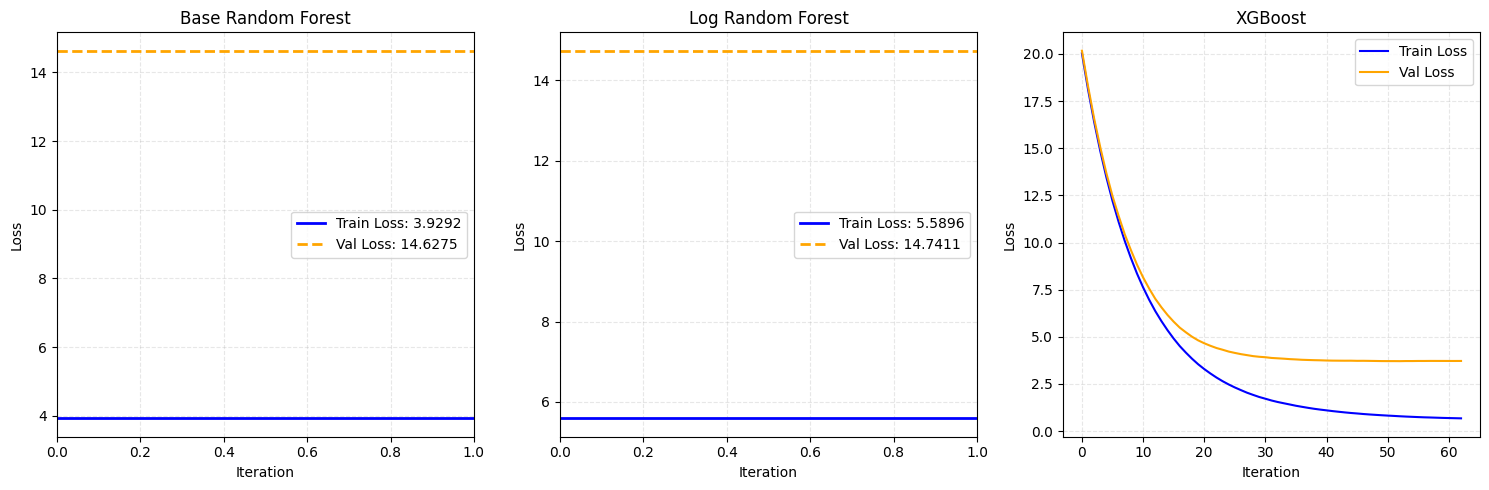

In [54]:
# Step 7: Plot Training Curves
training_pipeline.plot_training_curves(figsize=(15, 5))

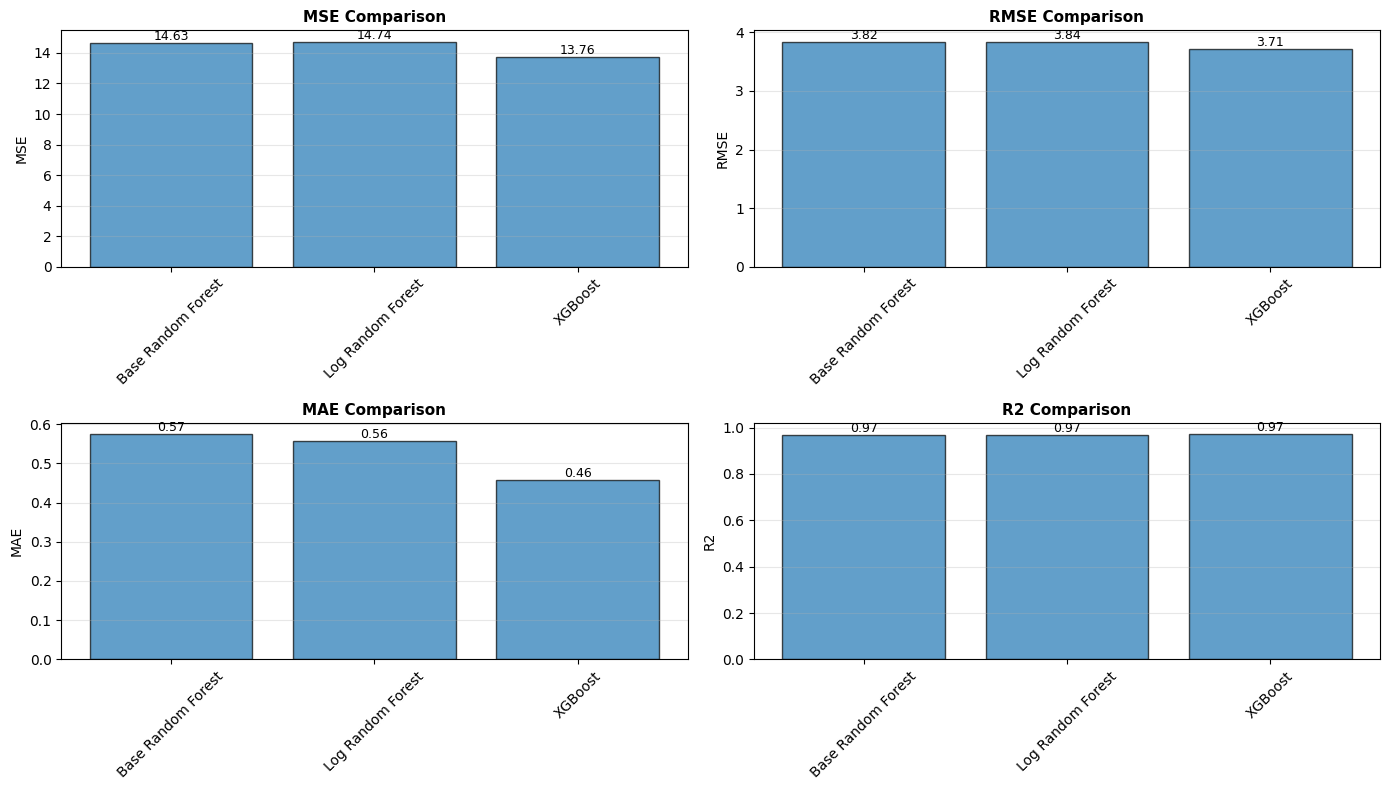

In [55]:
# Step 8: Plot Metrics Comparison
training_pipeline.plot_metrics_comparison(figsize=(14, 8))

Best model (lowest RMSE): XGBoost

Plotting predictions vs actual for XGBoost...


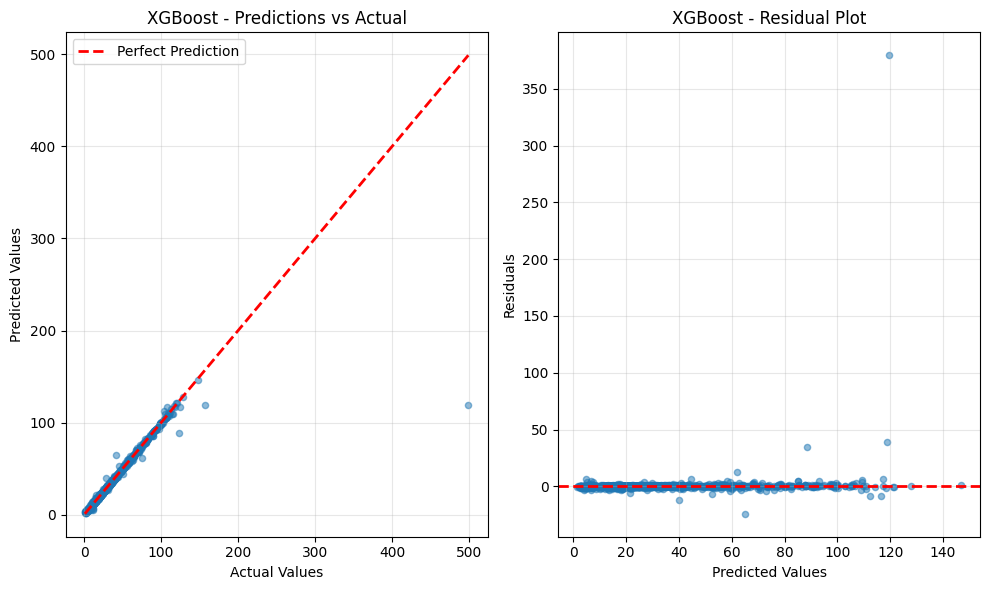

In [56]:
# Step 9: Plot Predictions vs Actual for Best Model
# Get the best model (lowest RMSE)
if training_pipeline.metrics:
    best_model = min(training_pipeline.metrics.items(), key=lambda x: x[1]['RMSE'])[0]
    print(f"Best model (lowest RMSE): {best_model}")
    print(f"\nPlotting predictions vs actual for {best_model}...")
    training_pipeline.plot_predictions_vs_actual(best_model, X_test, y_test, sample_size=2000)

# Inference Code

In [65]:
def load_model_and_pipeline(model_path="../models/best_model.pkl", 
                            preprocessing_path="../models/preprocessing_pipeline.pkl"):
    """
    Load the saved model and preprocessing pipeline.
    
    Parameters:
    -----------
    model_path : str or Path
        Path to saved model file
    preprocessing_path : str or Path
        Path to saved preprocessing pipeline file
        
    Returns:
    --------
    model : trained model
    preprocessing_pipeline : fitted preprocessing pipeline
    """
    import joblib
    
    model = joblib.load(model_path)
    preprocessing_pipeline = joblib.load(preprocessing_path)
    
    print(f"Loaded model from: {model_path}")
    print(f"Loaded preprocessing pipeline from: {preprocessing_path}")
    
    return model, preprocessing_pipeline


def predict_fare_amount(new_data, model=None, preprocessing_pipeline=None, 
                        model_path="../models/best_model.pkl",
                        preprocessing_path="../models/preprocessing_pipeline.pkl"):
    """
    Make predictions on new data.
    
    Parameters:
    -----------
    new_data : DataFrame
        New data with the same features as training data
        Must include: available_numerical + available_categorical columns
    model : trained model, optional
        If None, will load from model_path
    preprocessing_pipeline : fitted pipeline, optional
        If None, will load from preprocessing_path
    model_path : str or Path
        Path to saved model file (used if model is None)
    preprocessing_path : str or Path
        Path to saved preprocessing pipeline (used if preprocessing_pipeline is None)
        
    Returns:
    --------
    predictions : array
        Predicted fare amounts
    """
    import pandas as pd
    import numpy as np
    
    # Load model and pipeline if not provided
    if model is None:
        model, preprocessing_pipeline = load_model_and_pipeline(model_path, preprocessing_path)
    
    # Ensure new_data is a DataFrame
    if not isinstance(new_data, pd.DataFrame):
        new_data = pd.DataFrame(new_data)
    
    # Create zero flags if needed (using the helper function)
    numerical_with_flags = available_numerical.copy()
    zero_flag_cols = create_zero_flags(new_data, numerical_feature_list=numerical_with_flags)
    
    # Select all features including flags
    all_features = numerical_with_flags + available_categorical
    X_new = new_data[all_features]
    
    # Preprocess the data
    X_new_processed = preprocessing_pipeline.transform(X_new)
    
    # Make predictions
    predictions = model.predict(X_new_processed)
    
    return predictions


In [60]:
model, preprocessing_pipeline = load_model_and_pipeline(
    model_path="../models/best_model.pkl",
    preprocessing_path="../models/preprocessing_pipeline.pkl"
)

print(f"Model type: {type(model)}")
print(f"Preprocessing Pipeline type: {type(preprocessing_pipeline)}")

Loaded model from: ../models/best_model.pkl
Loaded preprocessing pipeline from: ../models/preprocessing_pipeline.pkl
Model type: <class 'xgboost.sklearn.XGBRegressor'>
Preprocessing Pipeline type: <class 'sklearn.pipeline.Pipeline'>


In [61]:
sample_df = sept_yellow_df.sample(3, random_state=42).drop(columns=["total_amount"])

numerical_with_flags = available_numerical.copy()
zero_flag_cols = create_zero_flags(sample_df, numerical_feature_list=numerical_with_flags)

all_features = numerical_with_flags + available_categorical
X_new = sample_df[all_features]
X_new_processed = preprocessing_pipeline.transform(X_new)

In [62]:
print(f"Numerical features used at inference: \n{available_numerical}")
print(f"Categorical features used at inference: \n{available_categorical}")

Numerical features used at inference: 
['trip_distance', 'trip_duration_minutes', 'passenger_count', 'fare_amount', 'tip_amount', 'tolls_amount', 'fare_per_mile', 'revenue_per_mile', 'tip_percentage', 'speed_mph', 'pickup_hour', 'pickup_dayofweek', 'pickup_month', 'is_weekend', 'is_rush_hour', 'is_night', 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'refund_amount', 'has_negative_fare', 'is_full_refund']
Categorical features used at inference: 
['VendorID', 'payment_type', 'RatecodeID', 'store_and_fwd_flag', 'time_of_day', 'negative_fare_category', 'vendor_payment_interaction']


In [63]:
sample_indices = sept_yellow_df.sample(3, random_state=42).index

sample_df = sept_yellow_df.loc[sample_indices].copy()
if 'total_amount' in sample_df.columns:
    sample_df_no_target = sample_df.drop(columns=["total_amount"])
else:
    sample_df_no_target = sample_df

print(f"Sample data shape for inference: {sample_df_no_target.shape}")
display(sample_df_no_target.head())

Sample data shape for inference: (3, 58)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_ratio,distance_per_minute,passengers_per_mile,vendor_payment_interaction,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,day_sin,day_cos
644165,2,2025-09-05 20:34:58,2025-09-05 21:01:38,1.0,2.96,NaN,None,137,114,0,...,0.000000,0.111000,0.337838,2_0,-0.866025,0.500000,-0.433884,-0.900969,0.848644,0.528964
237930,2,2025-09-18 15:10:56,2025-09-18 16:00:38,1.0,10.33,1.0,N,132,92,1,...,0.162354,0.207847,0.096805,2_1,-0.707107,-0.707107,0.433884,-0.900969,-0.485302,-0.874347
827884,2,2025-09-29 23:01:23,2025-09-29 23:17:24,1.0,2.26,NaN,None,186,142,0,...,0.000000,0.141103,0.442478,2_0,-0.258819,0.965926,0.000000,1.000000,-0.394356,0.918958


In [66]:
preds = predict_fare_amount(sample_df_no_target)
print(f"Predictions: {preds}")

Loaded model from: ../models/best_model.pkl
Loaded preprocessing pipeline from: ../models/preprocessing_pipeline.pkl
Predictions: [22.585016 67.55338  19.18402 ]


In [67]:
# With Ground Truth
actual = sept_yellow_df.loc[sample_indices, "total_amount"]

results = pd.DataFrame({
    "predicted_total_amount": preds,
    "actual_total_amount": actual.values
}, index=sample_indices)

display(results)

,predicted_total_amount,actual_total_amount
644165,22.585016,22.650000
237930,67.553383,67.629997
827884,19.184019,19.240000


### On Random Data

In [69]:
sample_data = {
    # =========================
    # Core numerical features
    # =========================
    "trip_distance": [3.2, 45.0, 5.0],              # normal, extreme, OOD-ish
    "trip_duration_minutes": [12.0, 90.0, 20.0],
    "passenger_count": [1, 3, 1],
    "fare_amount": [14.5, 180.0, -30.0],            # last one: negative fare scenario
    "tip_amount": [3.0, 25.0, 0.0],
    "tolls_amount": [0.0, 15.0, 0.0],

    # Derived numerical features (include these only if they are in available_numerical)
    "fare_per_mile": [
        14.5 / 3.2,                                 # ~4.53
        180.0 / 45.0,                               # 4.0
        -30.0 / 5.0,                                # -6.0 (OOD / strange)
    ],
    "revenue_per_mile": [
        (14.5 + 3.0 + 0.0) / 3.2,                   # ~5.47
        (180.0 + 25.0 + 15.0) / 45.0,               # ~4.89
        (-30.0 + 0.0 + 0.0) / 5.0,                  # -6.0
    ],
    "tip_percentage": [
        3.0 / 14.5,                                 # ~0.206
        25.0 / 180.0,                               # ~0.139
        0.0,                                        # no tip
    ],
    "speed_mph": [
        3.2 / (12.0 / 60.0),                        # ~16 mph
        45.0 / (90.0 / 60.0),                       # 30 mph
        5.0 / (20.0 / 60.0),                        # 15 mph
    ],

    # =========================
    # Time-based features
    # =========================
    "pickup_hour": [9, 18, 2],                      # morning, evening rush, night
    "pickup_dayofweek": [2, 5, 0],                  # e.g., Wed, Sat, Mon
    "pickup_month": [9, 9, 9],
    "is_weekend": [0, 1, 0],
    "is_rush_hour": [0, 1, 0],
    "is_night": [0, 0, 1],

    # Cyclical encodings (dummy but consistent)
    "hour_sin": [0.0, 0.0, -1.0],
    "hour_cos": [1.0, 1.0, 0.0],
    "dayofweek_sin": [0.0, 0.5, -0.5],
    "dayofweek_cos": [1.0, 0.8, 0.8],

    # =========================
    # New refund-related features
    # =========================
    "refund_amount": [
        0.0,                                        # normal trip, no refund
        20.0,                                       # partial refund for long trip
        30.0,                                       # full refund relative to |fare_amount|
    ],
    "has_negative_fare": [
        0,                                          # fare is positive
        0,                                          # fare is positive
        1,                                          # negative fare / refund scenario
    ],
    "is_full_refund": [
        0,                                          # no refund
        0,                                          # partial refund
        1,                                          # full refund
    ],
    "time_of_day": [
        "morning",                                  # positive, normal
        "evening",                                  # extreme but valid
        "night",                                    # OOD-ish, negative fare
    ],
    "negative_fare_category": [
        "none",                                     # no issue
        "partial_refund",                           # some refund
        "full_refund",                              # fully refunded / negative
    ],
    "vendor_payment_interaction": [
        "V1_card",                                  # Vendor 1 + card
        "V2_card",                                  # Vendor 2 + card
        "V1_full_refund",                           # Vendor 1 + refunded
    ],

    # =========================
    # Categorical trip features
    # (add/tweak to match available_categorical)
    # =========================
    "VendorID": [1, 2, 1],
    "RatecodeID": [1, 1, 1],
    "store_and_fwd_flag": ["N", "N", "N"],
    "payment_type": [1, 1, 1],                      # all credit card, for simplicity
    "PULocationID": [142, 75, 100],
    "DOLocationID": [236, 132, 200],
}

test_df_synth = pd.DataFrame(sample_data)

pred_on_synth = predict_fare_amount(test_df_synth)
print(f"Prediction on synthetic data: {float(pred_on_synth[0])}")

Loaded model from: ../models/best_model.pkl
Loaded preprocessing pipeline from: ../models/preprocessing_pipeline.pkl
Prediction on synthetic data: 19.754125595092773


## Adding More Models

To add more models to the pipeline, simply use:

```python
# Example: Add LightGBM
try:
    import lightgbm as lgb
    lgb_model = lgb.LGBMRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    trainining_pipeline.add_model('LightGBM', lgb_model)
except ImportError:
    print("LightGBM not installed. Install with: pip install lightgbm")

# Example: Add Linear Regression
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
trainining_pipeline.add_model('Linear Regression', lr_model)

# Then retrain all models
trainining_pipeline.train_all_models(
    X_train=X_train_split,
    y_train=y_train_split,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test
)
```
